# Lending Club Case Study

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load data

In [ ]:
csvFile = 'loan.csv'

In [ ]:
loans = pd.read_csv(csvFile)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

In [ ]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


**Info Summary:**
1. There are 39717 enteries (rows of data)
2. 111 columns of which 74 of them are float type, 13 are integer type and 24 are object type. (But there could be some date type, which is to be checked)
3. Column 47 has mixed type as per the warning above, need to be analyzed further later


**Data Clean up**
1. remove all invalid rows (rows which has all column enteries which are NAN)
2. remove all invalid columns (columns which has all row enteries which are NAN)
3. remove all numeric data elements where there is no change in data 
4. remove all string/object columns where data elements are same
5. convert all columns where date type is present to datetime type

### 1. remove all invalid rows 

Remove all the rows which has all column enteries which are NAN

In [ ]:
loans.dropna(axis=0, how='all', inplace=True)

### 2. remove all invalid columns 

Remove all columns which has all row enteries which are NAN

In [ ]:
loans.dropna(axis=1, how='all', inplace=True)

In [ ]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39717 entries, 0 to 39716
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

From above it is clear that more than 50% of the columns did not have data and cannot be used for analysis, But number of data elements(rows or indexes) though has remained same which means we did not have any invalid data points

### 3. remove all columns where there is no variation in data 

There are multiple ways how we can remove the data elements. 
For numeric data we can check for standard deviation to be zero
Check for unique value counts in all columns and if the number of unique values is one, we can drop that columns

In [ ]:
loans.drop(loans.loc[:,loans.nunique() == 1].columns, inplace=True, axis=1)

In [ ]:
loans.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39717 entries, 0 to 39716
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       39717 non-null  int64  
 1   member_id                39717 non-null  int64  
 2   loan_amnt                39717 non-null  int64  
 3   funded_amnt              39717 non-null  int64  
 4   funded_amnt_inv          39717 non-null  float64
 5   term                     39717 non-null  object 
 6   int_rate                 39717 non-null  object 
 7   installment              39717 non-null  float64
 8   grade                    39717 non-null  object 
 9   sub_grade                39717 non-null  object 
 10  emp_title                37258 non-null  object 
 11  emp_length               38642 non-null  object 
 12  home_ownership           39717 non-null  object 
 13  annual_inc               39717 non-null  float64
 14  verification_status   

There were 9 columns where there were no variation in numeric data(standard deviation is zero) and no change in string data, which are removed

### 4. Convert all the date columns from string to datetime format

In [ ]:
import datetime
updateNaT = lambda x : datetime.date(9999, 12,31) if pd.isnull(x) else x

In [ ]:
dateColumns = ['issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']

In [ ]:
for col in dateColumns:
  loans[col] = pd.to_datetime(loans[col], format="%b-%y").apply(updateNaT)

**earliest_cr_line** column has mixed date time type

In [ ]:
earliest_cr_line_data = loans['earliest_cr_line']
# earliest_cr_line_data = pd.to_datetime(earliest_cr_line_data, format="%b-%y", errors='ignore')

In [ ]:
earliest_cr_line_data

0        Jan-85
1        Apr-99
2        Nov-01
3        Feb-96
4        Jan-96
          ...  
39712    Nov-90
39713    Dec-86
39714    Oct-98
39715    Nov-88
39716    Oct-03
Name: earliest_cr_line, Length: 39717, dtype: object

### Clean up column mths_since_last_delinq

Fill value -1 for invalid data

In [ ]:
loans.mths_since_last_delinq.fillna(value=-1, inplace=True)
loans.mths_since_last_delinq = loans.mths_since_last_delinq.astype(int)

### clean up column mths_since_last_record

In [ ]:
loans.mths_since_last_record.fillna(value=-1, inplace=True)
loans.mths_since_last_record = loans.mths_since_last_record.astype(int)

### Clean up int_rate column

The interest rate column is a string column, which is to be converted to numeric for better analysis.</br>
int_rate column ends with '%' which is to be stripped

In [ ]:
loans.int_rate = loans.int_rate.apply(lambda x : float(x[:-1]))

### Clean up revol_util column

The revol_util column also is a string column and ends with '%'. It should be converted into numeric column and invalid columns are to be filled with -1

In [ ]:
loans.revol_util.fillna(value='-1%', inplace=True)
loans.revol_util = list(map(lambda x : float(x[:-1]), loans.revol_util.values))

### Clean up **desc** column

In [ ]:
loans.desc.fillna(' ' ,inplace= True)
loans['desc'] = loans.desc.str.replace('<br>' , '')
loans['desc'] = loans.desc.str.replace('Borrower added on ' , '')
loans['desc'] = loans.desc.str.replace('(1[0-2]|0[1-9])/(3[01]|[12][0-9]|0[1-9])/(1[0-2]|0[1-9])' , '')
loans['desc'] = loans.desc.str.replace('>' ,'')

### clean up **emp_title** column

The emp_title column where the data is not present can be updated with value of 'Not Given'

In [ ]:
loans.emp_title.fillna('Not Given' ,inplace= True)

### clean up **emp_length** column

The invalid enteries of the column is updated with 'Not Given'

In [ ]:
loans.emp_length.fillna('Not Given' ,inplace= True)

### clean up **title** column

In [ ]:
loans.title.fillna('Not Specified', inplace=True)

### Clean up pub_rec_bankruptcies column

In [ ]:
loans.pub_rec_bankruptcies.fillna(-1.0, inplace=True)

### Handling id, member id and url

In [ ]:
loans.agg(['count', 'nunique']).transpose()

,count,nunique
id,39717,39717
member_id,39717,39717
loan_amnt,39717,885
funded_amnt,39717,1041
funded_amnt_inv,39717,8205
term,39717,2
int_rate,39717,371
installment,39717,15383
grade,39717,7
sub_grade,39717,35


The columns **id**, **member_id** and **url** have all the columns values being unique. <br>
So we can easily drop two of the three columns and set one as the index. <br>
So we will retain only **id** column and drop the other two

In [ ]:
loans.set_index('id', inplace=True)
loans.drop(columns=['member_id', 'url'], inplace=True)

### Removing columns by observation

From the info earlier, we saw that column **next_pymnt_d** has very less data(1140), but let us plot the payment_status and then conclude

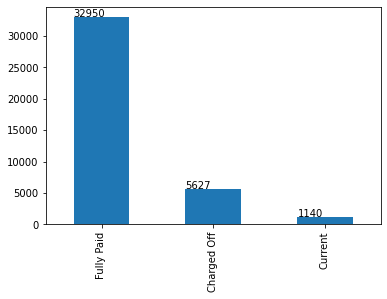

In [ ]:
ax = loans.loan_status.value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

From the plot above we can see that, the number of loans with status **Current** is equal to 1140 which is exactly the number of data points in column **next_pymnt_d**

In [ ]:
loans[loans.loan_status == 'Current']['next_pymnt_d'].unique()

array([Timestamp('2016-06-01 00:00:00'), Timestamp('2016-07-01 00:00:00')],
      dtype=object)

Since there are only two values and may not be very interesting to analyze, we will delete the column

In [ ]:
loans.drop(columns=['next_pymnt_d'], inplace=True)

### Final Data Check

In [ ]:
loans.isna().sum()

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title                  0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
desc                       0
purpose                    0
title                      0
zip_code                   0
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_in

Since there are no null columns, missing data is added with default values/ invalid value indicators

## Outlier Analysis

Let us get use the describe function to get the stats of all the numeric columns

In [ ]:
loans.describe(percentiles=[0.10, 0.25, 0.50, 0.75, 0.90]).transpose()

,count,mean,std,min,10%,25%,50%,75%,90%,max
loan_amnt,39717.0,11219.443815,7456.670694,500.00,3200.000000,5500.00,10000.000000,15000.00000,22000.000000,3.500000e+04
funded_amnt,39717.0,10947.713196,7187.238670,500.00,3200.000000,5400.00,9600.000000,15000.00000,21000.000000,3.500000e+04
funded_amnt_inv,39717.0,10397.448868,7128.450439,0.00,2950.000000,5000.00,8975.000000,14400.00000,20000.000000,3.500000e+04
int_rate,39717.0,12.021177,3.724825,5.42,7.140000,9.25,11.860000,14.59000,16.890000,2.459000e+01
installment,39717.0,324.561922,208.874874,15.69,99.450000,167.02,280.220000,430.78000,622.952000,1.305190e+03
annual_inc,39717.0,68968.926377,63793.765790,4000.00,30000.000000,40404.00,59000.000000,82300.00000,116000.000000,6.000000e+06
dti,39717.0,13.315130,6.678594,0.00,4.080000,8.17,13.400000,18.60000,22.330000,2.999000e+01
delinq_2yrs,39717.0,0.146512,0.491812,0.00,0.000000,0.00,0.000000,0.00000,1.000000,1.100000e+01
inq_last_6mths,39717.0,0.869200,1.070219,0.00,0.000000,0.00,1.000000,1.00000,2.000000,8.000000e+00
mths_since_last_delinq,39717.0,12.039882,21.965683,-1.00,-1.000000,-1.00,-1.000000,21.00000,48.000000,1.200000e+02


The describe function gives a good overview for all the numeric variables, But each has to be analyzed individually to understand and remove outliers better

### annual_inc

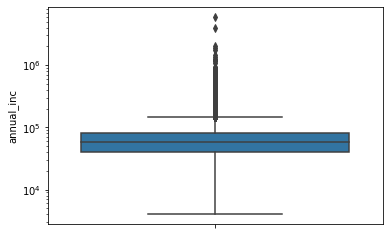

In [ ]:
sns.boxplot(y='annual_inc', data=loans)
plt.yscale('log')

In [ ]:
quantileRange = [0,0.001,0.01,.025,.05,.1, .25, .5, .75,.975 ,.99,1]

In [ ]:
loans.annual_inc.quantile(quantileRange)

0.000       4000.000
0.001       8408.592
0.010      14400.000
0.025      19200.000
0.050      24000.000
0.100      30000.000
0.250      40404.000
0.500      59000.000
0.750      82300.000
0.975     175000.000
0.990     234999.360
1.000    6000000.000
Name: annual_inc, dtype: float64

So from the above box plot and values, we can see that there are outliers present in the dataset, so let us take 99% of the data and rest can be left out

In [ ]:
loans = loans[loans.annual_inc.between(loans.annual_inc.quantile(0), loans.annual_inc.quantile(.99))]

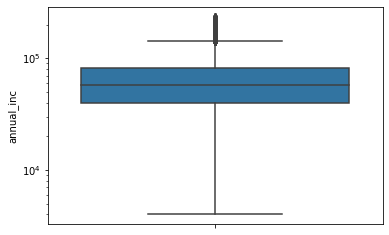

In [ ]:
sns.boxplot(y='annual_inc', data=loans)
plt.yscale('log')

Now the outliers in annual_inc is removed

### loan_amnt

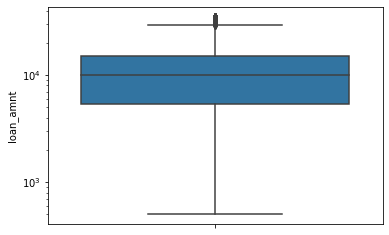

In [ ]:
sns.boxplot(y='loan_amnt', data=loans)
plt.yscale('log')

In [ ]:
loans.loan_amnt.quantile(quantileRange)

0.000      500.0
0.001     1000.0
0.010     1200.0
0.025     1700.0
0.050     2400.0
0.100     3200.0
0.250     5400.0
0.500    10000.0
0.750    15000.0
0.975    30000.0
0.990    35000.0
1.000    35000.0
Name: loan_amnt, dtype: float64

There are not many outliers in the loan_amnt, so this column can be used as it is

### installment

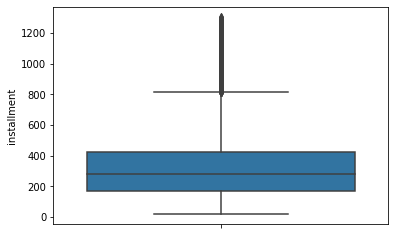

In [ ]:
sns.boxplot(y='installment', data=loans)

In [ ]:
loans.installment.quantile(quantileRange)

0.000      15.69000
0.001      28.76314
0.010      37.56080
0.025      52.72900
0.050      71.02000
0.100      99.26600
0.250     166.19000
0.500     278.92000
0.750     426.10000
0.975     841.24000
0.990     921.11000
1.000    1305.19000
Name: installment, dtype: float64

### dti

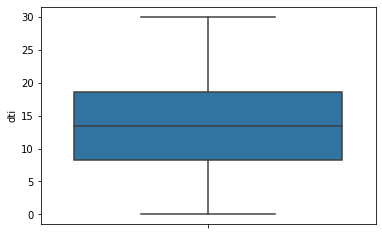

In [ ]:
sns.boxplot(y='dti', data=loans)

Clear from boxplot, that there is no outlier

### total_pymnt

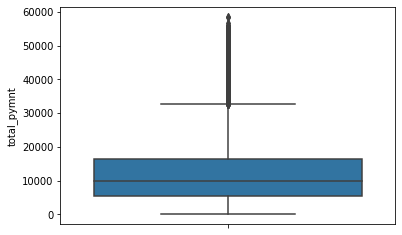

In [ ]:
sns.boxplot(y='total_pymnt', data=loans)

In [ ]:
loans.total_pymnt.quantile(quantileRange)

0.000        0.000000
0.001       97.541940
0.010      759.452600
0.025     1240.153572
0.050     1880.992346
0.100     2956.576386
0.250     5561.299425
0.500     9830.255586
0.750    16429.424275
0.975    35008.490601
0.990    41828.348798
1.000    58563.679930
Name: total_pymnt, dtype: float64

No outliers found

## UNIVARIATE ANALYSIS

#### Helper functions

##### count plot

In [ ]:
def get_totals_count(ax):

    heights = [x.get_height() for x in ax.patches]
    return sum(heights)

In [ ]:
def plot_count_chart(ColdataSeries, figsize=(20,10), logScale=False, isPercentage=True):
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=ColdataSeries)
    
    plt.tight_layout()
    patch_totals = get_totals_count(ax)
    for p in ax.patches:
      if isPercentage:
        ax.annotate('{:.2f}% ({})'.format(p.get_height()*100/patch_totals, 
                                          int(p.get_height())),
                    (p.get_x() * 1.005, p.get_height() * 1.005))
      else:
        ax.annotate('{}'.format(int(p.get_height())),
                    (p.get_x() * 1.005, p.get_height() * 1.005))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    if logScale:
        plt.yscale('log')
    plt.tight_layout()
    plt.show()

##### Rank-Frequency Plot

In [ ]:
def plot_rank_frequency(ColdataSeries, dataColumnName):
    sns.set(style="whitegrid")
    data = pd.DataFrame({'Frequency' : ColdataSeries.value_counts() })
    data['rank'] = data.rank(ascending=False)
    plt.title("Rank - Frequency plot for {}".format(dataColumnName))
    plt.ylabel("Frequency")
    plt.xlabel("Rank")
    plt.loglog(data['rank'], data['Frequency'], basex=10)

### Bar Plot with Table


In [ ]:
def bar_plot( x,y ,data ,sizerow=10 , sizecolumn =10 ,tabletoggle =True , axistoggle = 'off', logScale=False):
  ax = data.groupby([x,y]).size().unstack().plot(kind='bar',stacked=True,figsize=(sizerow , sizecolumn),table = tabletoggle )
  plt.axis(axistoggle)
  plt.tight_layout()
  if logScale:
        plt.yscale('log')
  plt.show()


##### Distribution Plot

In [ ]:
# to plot continuous data
def plot_distPlot(dataSeries, xLabel, yLabel='Count', bins=10,logScale=False, fontsize=15, figsize=(4,3)):
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)
    ax = sns.distplot(dataSeries, kde=False, color='green', bins=bins)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.xlabel(xLabel, fontsize=fontsize)
    plt.ylabel(yLabel,fontsize=fontsize)
    if logScale:
        plt.yscale('log')

##### Group Plot

In [ ]:
def plot_groupPlot(dataframe, index:list, columns, logScale=False, figsize=(4,3)):
    dataframe.pivot_table(index=index, columns=columns, aggfunc='size', fill_value=0).plot(kind='bar',figsize=figsize, 
                                                                                           logy=logScale)

###Amount Distribution

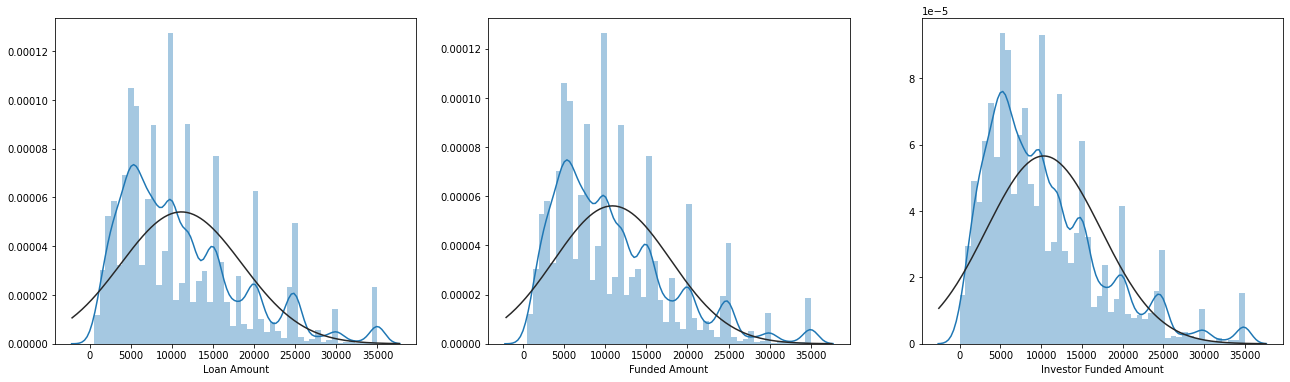

In [ ]:
plt.subplots(figsize=(22,6)) 
plt.subplot(1,3,1)
sns.distplot(loans.loan_amnt,fit = norm)
plt.xlabel('Loan Amount')
plt.subplot(1,3,2)
sns.distplot(loans.funded_amnt,fit = norm )
plt.xlabel('Funded Amount')
plt.subplot(1,3,3)
sns.distplot(loans.funded_amnt_inv,fit = norm)
plt.xlabel('Investor Funded Amount')
plt.show()

### Loan Status

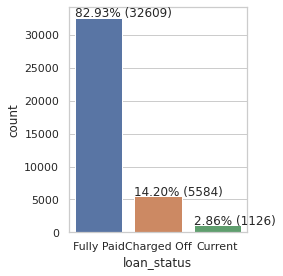

In [ ]:
plot_count_chart(loans.loan_status, (4,4))

It can be observed that around 14.20% of loans are charged off

### home_ownership

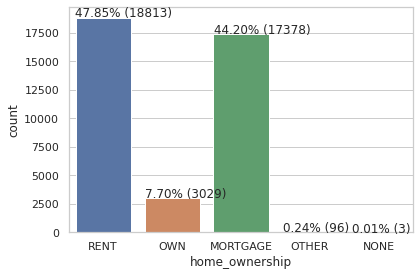

In [ ]:
plot_count_chart(loans.home_ownership, (6,4))

### purpose of loan

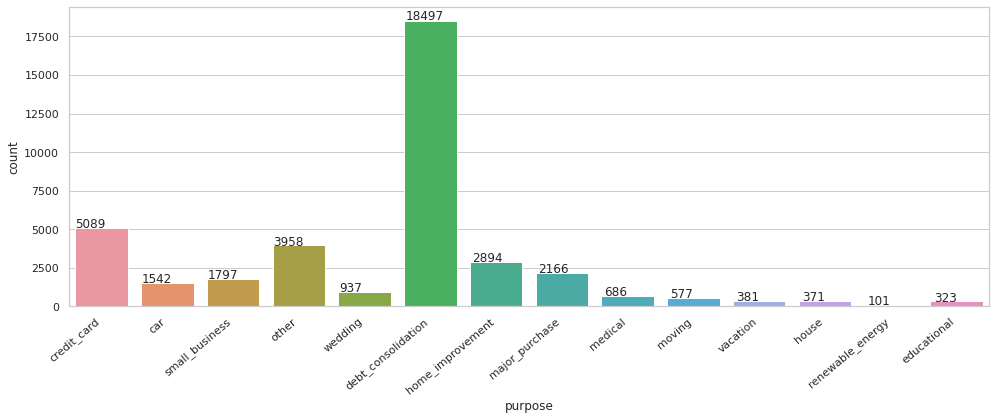

In [ ]:
plot_count_chart(loans.purpose, (14,6), isPercentage=False)

It can be observed that around 47% of the loans are taken for debt consolidation and the next highest being around ~13% is for credit card payments. So majorly loans are taken for existing debt's

### verification status

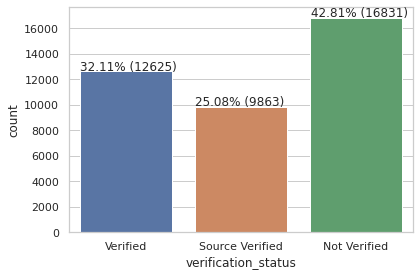

In [ ]:
plot_count_chart(loans.verification_status, (6,4))

Around 42.81% of loans are not verified

### Term

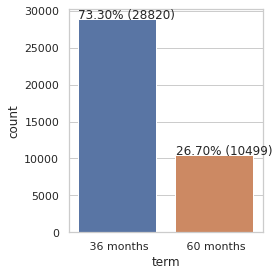

In [ ]:
plot_count_chart(loans.term, (4,4))

Around 73.3% of the loans are for 36 months. i.e many people take short term loans compared to long term loans

### delinq_2yrs

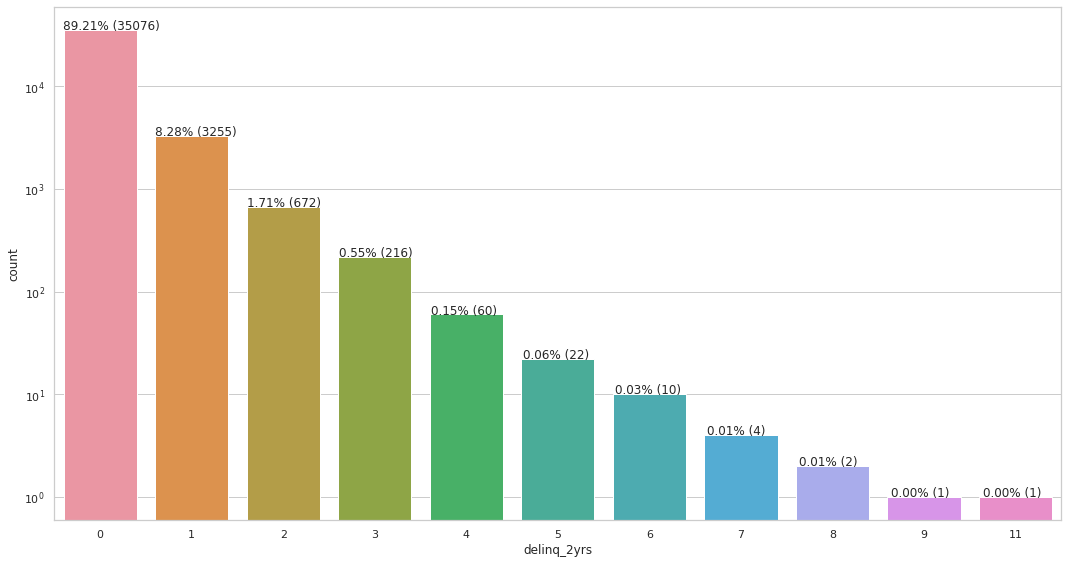

In [ ]:
plot_count_chart(loans.delinq_2yrs, figsize=(15,8), logScale=True)

People tend to have lesser number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

### Numbers of years of Experience

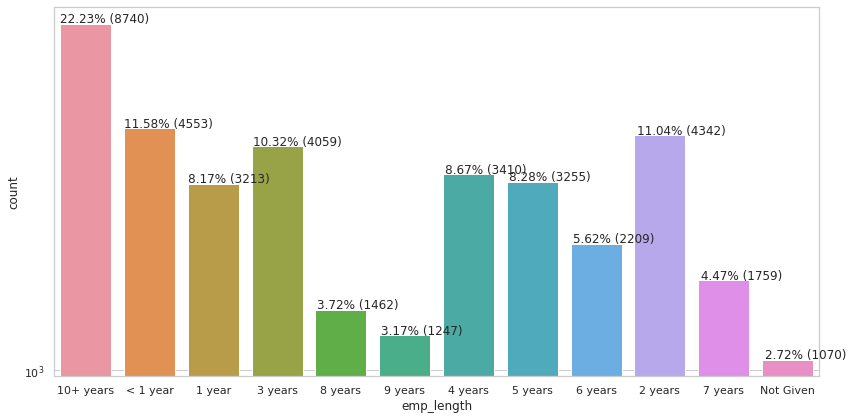

In [ ]:
plot_count_chart(loans.emp_length, logScale=True, figsize=(12,6))

People with 10+ years of experience take more loans.
The observation can be broken into 2 chunks, people with less than 4 years of experience and 10+ years of experience take more loans

### Grades of loan

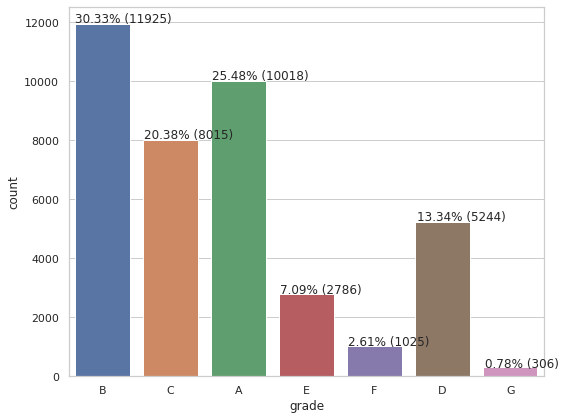

In [ ]:
plot_count_chart(loans.grade, figsize=(8, 6))

There are more lower grade loans

### no of inquires in last 6 months

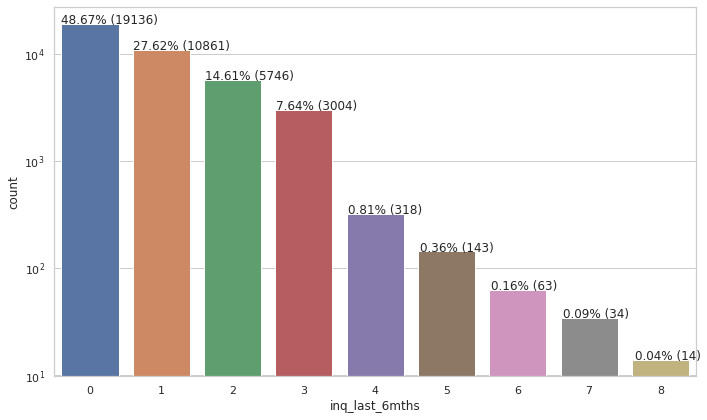

In [ ]:
plot_count_chart(loans.inq_last_6mths, logScale=True, figsize=(10,6))

### Months since last delinquency

## SEGMENTED UNIVARIATE ANALYSIS

###Region Analysis

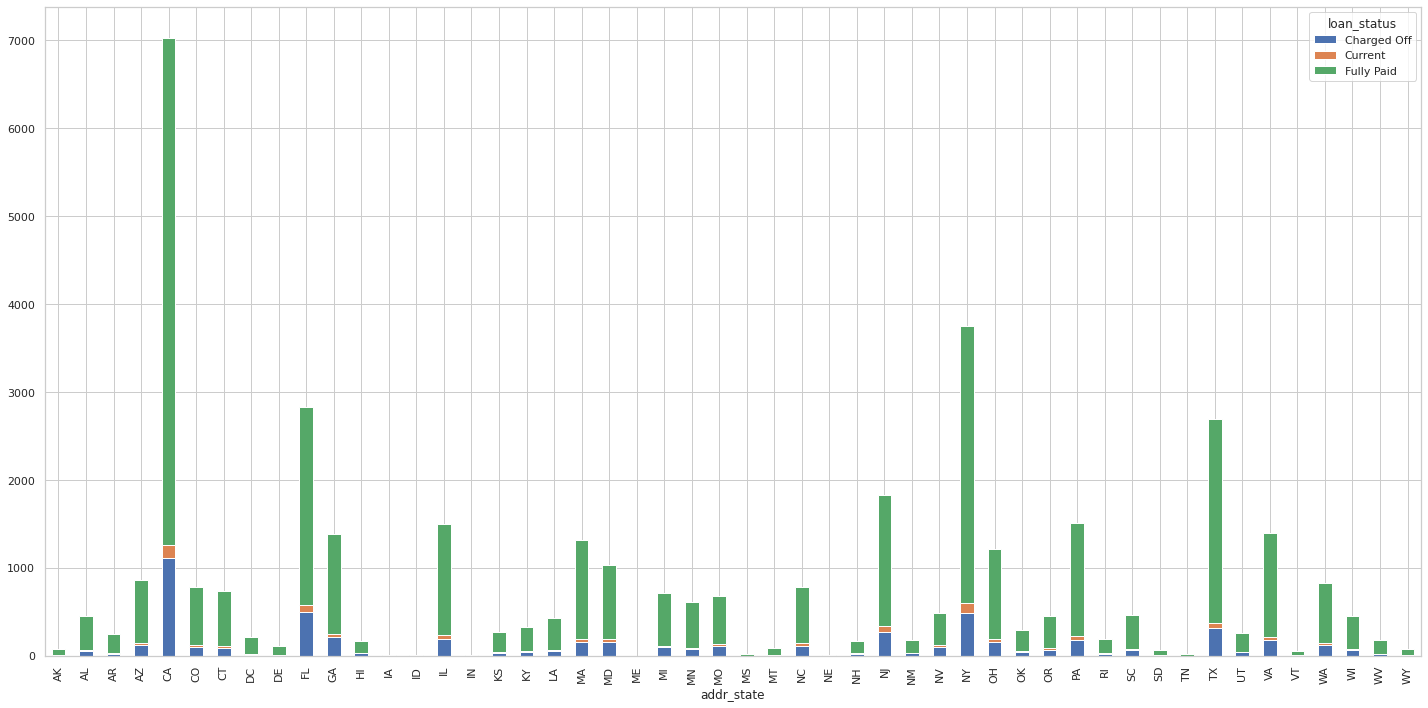

In [ ]:
bar_plot('addr_state', 'loan_status' ,data=loans, axistoggle= 'on',tabletoggle= False,sizerow= 20)

In [ ]:
pd.crosstab([loans.addr_state],loans.loan_status,values=loans.loan_amnt,aggfunc='count' ,normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
addr_state,,,
AK,0.177215,0.025316,0.797468
AL,0.120267,0.037862,0.841871
AR,0.110204,0.040816,0.848980
AZ,0.139241,0.034522,0.826237
CA,0.158703,0.021189,0.820108
CO,0.124041,0.033248,0.842711
CT,0.127717,0.032609,0.839674
DC,0.070093,0.014019,0.915888
DE,0.105263,0.008772,0.885965


In [ ]:
#map states to regions
states = {
     'AK' :  'West' ,  'AL' :  'South' ,  'AR' :  'South' ,  'AZ' :  'West' ,  'CA' :  'West' ,  'CO' :  'West' ,  'CT' :  'Northeast' ,
       'DC' :  'South' ,  'DE' :  'South' ,  'FL' :  'South' ,  'GA' :  'South' ,  'HI' :  'West' ,  'IA' :  'Midwest' ,  'ID' :  'West' , 
        'IL' :  'Midwest' ,  'IN' :  'Midwest' ,  'KS' :  'Midwest' ,  'KY' :  'South' ,  'LA' :  'South' ,  'MA' :  'Northeast' ,  'MD' :  'South' , 
         'ME' :  'Northeast' ,  'MI' :  'Midwest' ,  'MN' :  'Midwest' ,  'MO' :  'Midwest' ,  'MS' :  'South' ,  'MT' :  'West' ,  'NC' :  'South' ,
          'ND' :  'Midwest' ,  'NE' :  'Midwest' ,  'NH' :  'Northeast' ,  'NJ' :  'Northeast' ,  'NM' :  'West' ,  'NV' :  'West' ,  'NY' :  'Northeast' , 
          'OH' :  'Midwest' ,  'OK' :  'South' ,  'OR' :  'West' ,  'PA' :  'Northeast' ,  'RI' :  'Northeast' ,  'SC' :  'South' ,  'SD' :  'Midwest' , 
          'TN' :  'South' ,  'TX' :  'South' ,  'UT' :  'West' ,  'VA' :  'South' ,  'VT' :  'Northeast' ,  'WA' :  'West' ,  'WI' :  'Midwest' , 
          'WV' :  'South' ,  'WY' :  'West' 
}
loans['Region']= loans['addr_state'].map(states)


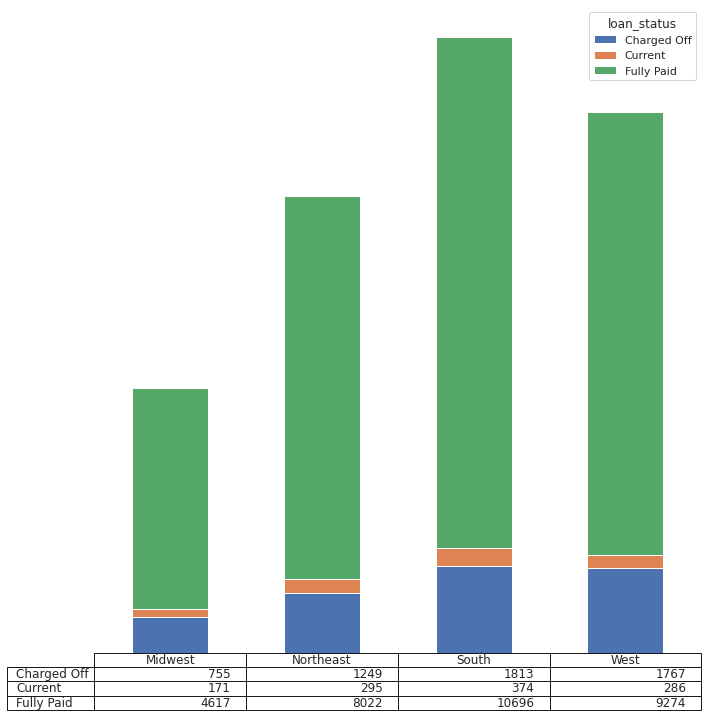

In [ ]:
bar_plot('Region' , 'loan_status', data=loans)


In [ ]:
pd.crosstab([loans.Region],loans.loan_status,values=loans.loan_amnt,aggfunc='count' ,normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
Region,,,
Midwest,0.136208,0.030850,0.832942
Northeast,0.130567,0.030838,0.838595
South,0.140728,0.029031,0.830241
West,0.155999,0.025249,0.818752


Now let us look at multiple factors with respect to loan status

### Verification Status vs Loan Status

In [ ]:
pd.crosstab(index=  [loans.verification_status],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
verification_status,,,
Not Verified,0.126552,0.013487,0.859961
Source Verified,0.144175,0.031025,0.824800
Verified,0.160950,0.046970,0.792079


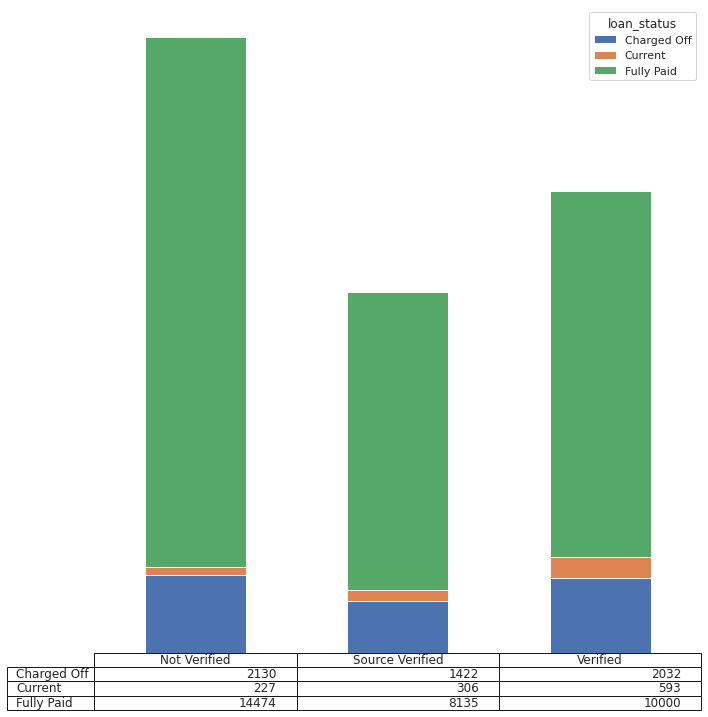

In [ ]:
bar_plot('verification_status' ,'loan_status', data=loans)

People who has verification status as verified are the ones with highest chances to be charged off

### Employment Length vs Loan Status

In [ ]:
pd.crosstab(index=  [loans.emp_length],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
emp_length,,,
1 year,0.141612,0.021475,0.836913
10+ years,0.150572,0.044165,0.805263
2 years,0.129203,0.022340,0.848457
3 years,0.135748,0.020202,0.844050
4 years,0.133724,0.027566,0.838710
5 years,0.140092,0.026728,0.833180
6 years,0.138072,0.026256,0.835672
7 years,0.148948,0.035247,0.815804
8 years,0.138851,0.029412,0.831737


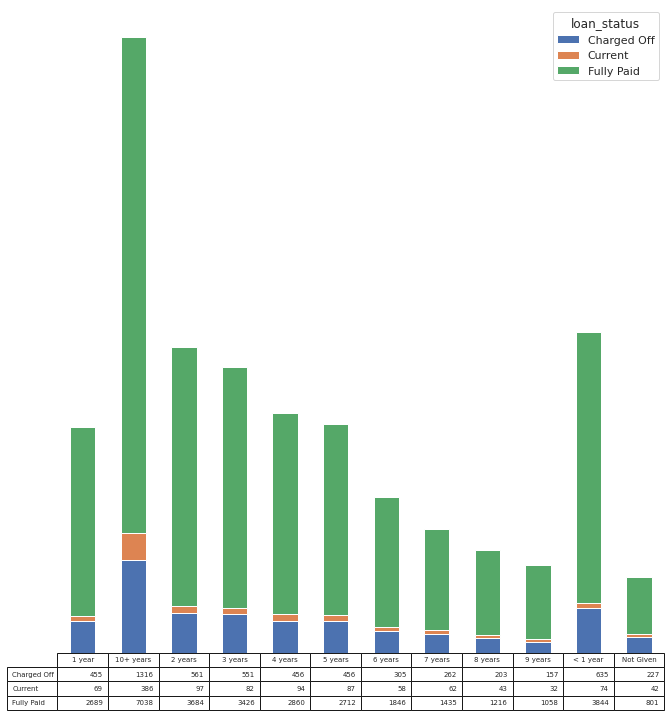

In [ ]:
bar_plot('emp_length' ,'loan_status', data=loans)

People who do not specify employment length have atleast 6% higher chances of not paying loan

### Grade vs Loan Status

In [ ]:
pd.crosstab(index=  [loans.grade],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
grade,,,
A,0.059992,0.003993,0.936015
B,0.118574,0.028847,0.852579
C,0.167436,0.032689,0.799875
D,0.212052,0.041190,0.746758
E,0.252692,0.063173,0.684135
F,0.304390,0.069268,0.626341
G,0.323529,0.055556,0.620915


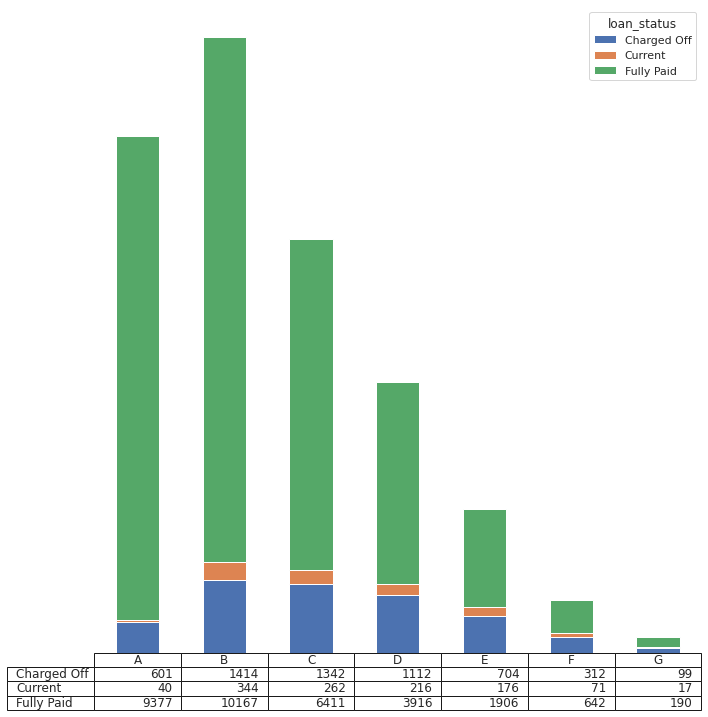

In [ ]:
bar_plot('grade','loan_status', data = loans)

In [ ]:
pd.crosstab(index=  [loans.sub_grade],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
sub_grade,,,
A1,0.026502,0.000000,0.973498
A2,0.049366,0.000000,0.950634
A3,0.057254,0.000000,0.942746
A4,0.062086,0.004534,0.933380
A5,0.079383,0.009923,0.910695
B1,0.093458,0.018142,0.888400
B2,0.110619,0.027532,0.861849
B3,0.116158,0.031900,0.851942
B4,0.131253,0.029612,0.839136


As the grade increases, chances of loan being charged off increases, same is observed with sub grade

### Home Ownership vs Loan Status

In [ ]:
pd.crosstab(index=  [loans.home_ownership],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
home_ownership,,,
MORTGAGE,0.132466,0.036138,0.831396
NONE,0.000000,0.000000,1.000000
OTHER,0.187500,0.000000,0.812500
OWN,0.145262,0.027072,0.827666
RENT,0.150109,0.022112,0.827779


People whoes home ownership status is other has higher chances of being charged off

### Loan Purpose vs Loan Status

In [ ]:
pd.crosstab(index=  [loans.purpose],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
purpose,,,
car,0.103761,0.032425,0.863813
credit_card,0.105522,0.020043,0.874435
debt_consolidation,0.148781,0.031356,0.819863
educational,0.170279,0.000000,0.829721
home_improvement,0.116793,0.033518,0.849689
house,0.156334,0.037736,0.805930
major_purchase,0.101570,0.017082,0.881348
medical,0.154519,0.017493,0.827988
moving,0.157712,0.012132,0.830156


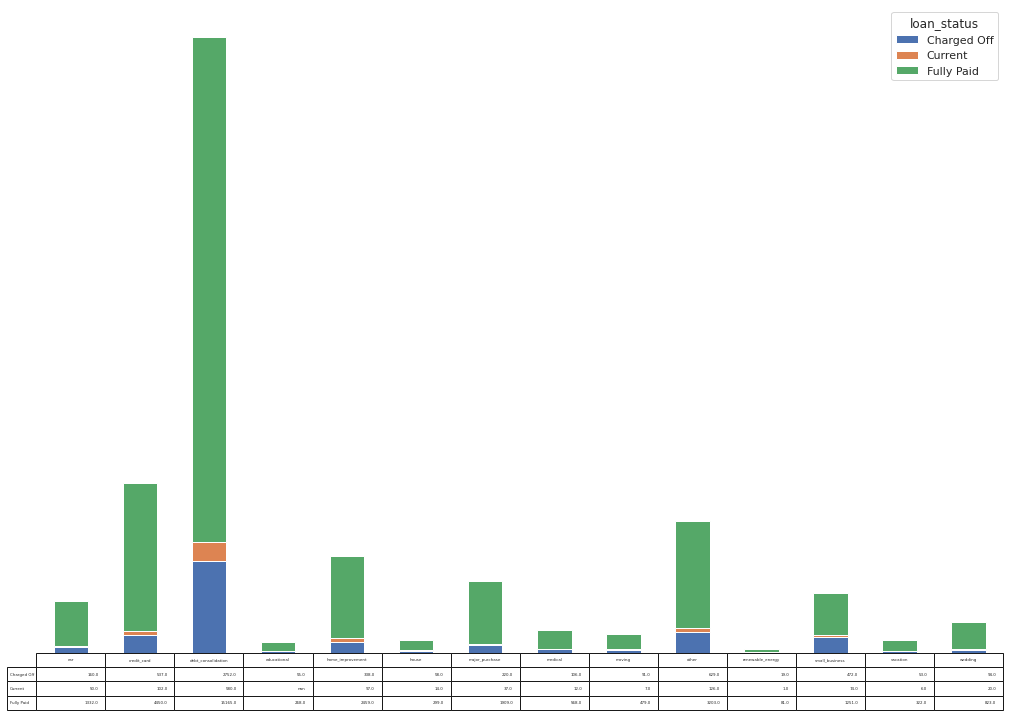

In [ ]:
bar_plot('purpose','loan_status', data = loans, sizerow=15, sizecolumn=10)

Loan's given to small business has around 26% chances of being charged off

### No Of Inquiry vs Loan Status

In [ ]:
pd.crosstab(index=  [loans.inq_last_6mths],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
inq_last_6mths,,,
0,0.118154,0.030466,0.851380
1,0.153025,0.028174,0.818801
2,0.163592,0.027323,0.809085
3,0.204394,0.021638,0.773968
4,0.160377,0.031447,0.808176
5,0.188811,0.013986,0.797203
6,0.253968,0.015873,0.730159
7,0.294118,0.029412,0.676471
8,0.214286,0.071429,0.714286


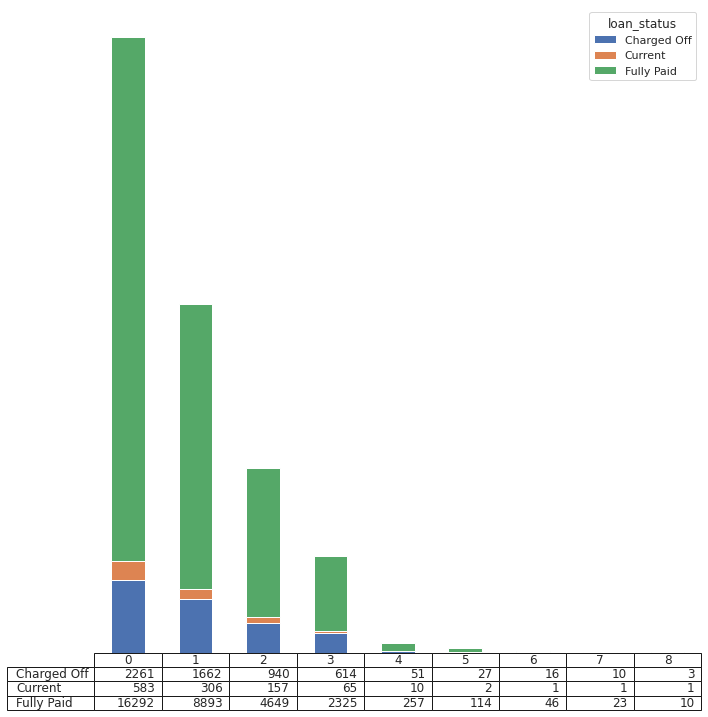

In [ ]:
bar_plot('inq_last_6mths','loan_status', data = loans)

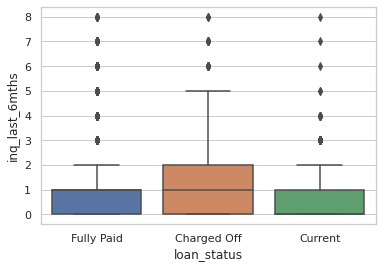

In [ ]:
sns.set(style="whitegrid")
sns.boxplot(y=loans.inq_last_6mths , x= loans.loan_status) 

People with number of inquiry greater than 4 will have more chances of loan being charged off, highest being at 7

### Derogatory public record vs Loan Status

In [ ]:
pd.crosstab(index=  [loans.pub_rec],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
pub_rec,,,
0,0.13759,0.029023,0.833387
1,0.22168,0.020996,0.757324
2,0.20000,0.060000,0.740000
3,0.00000,0.000000,1.000000
4,0.00000,0.000000,1.000000


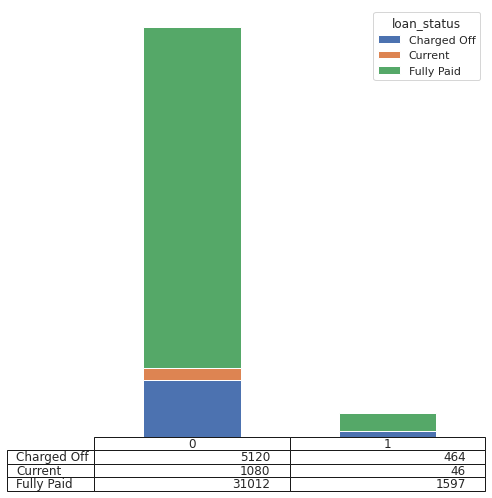

In [ ]:
loans['pub_rec_exists']= loans.pub_rec.apply(lambda x: 1 if x>0 else 0)
bar_plot('pub_rec_exists' , 'loan_status',sizerow=7 , sizecolumn=7,data = loans)

People with more than one derogatory public record have more than 20% chances of loan being charged off

### Public record bankruptcies vs Loan Status

In [ ]:
pd.crosstab(index=  [loans.pub_rec_bankruptcies],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
pub_rec_bankruptcies,,,
-1.0,0.168605,0.000000,0.831395
0.0,0.138036,0.029415,0.832549
1.0,0.218563,0.022156,0.759281
2.0,0.285714,0.285714,0.428571


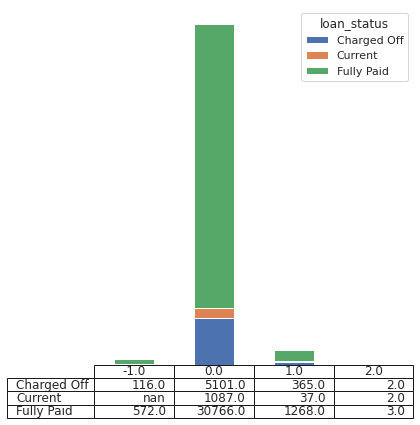

In [ ]:
bar_plot('pub_rec_bankruptcies' , 'loan_status',sizerow=6 , sizecolumn=6,data = loans)

People with atleast 1 public record bankruptcies have more than 20 % chances of loan being charged off <br>
"-1" indicates invalid values

### Interest Rate vs Loan Status

We will bucketize the interest rates first and then do the analysis

In [ ]:
loans['interest_bin'] = pd.qcut(loans.int_rate, 4, labels=['<0.09' , '<.12' , '<.15' , '<.25'],duplicates = 'drop')

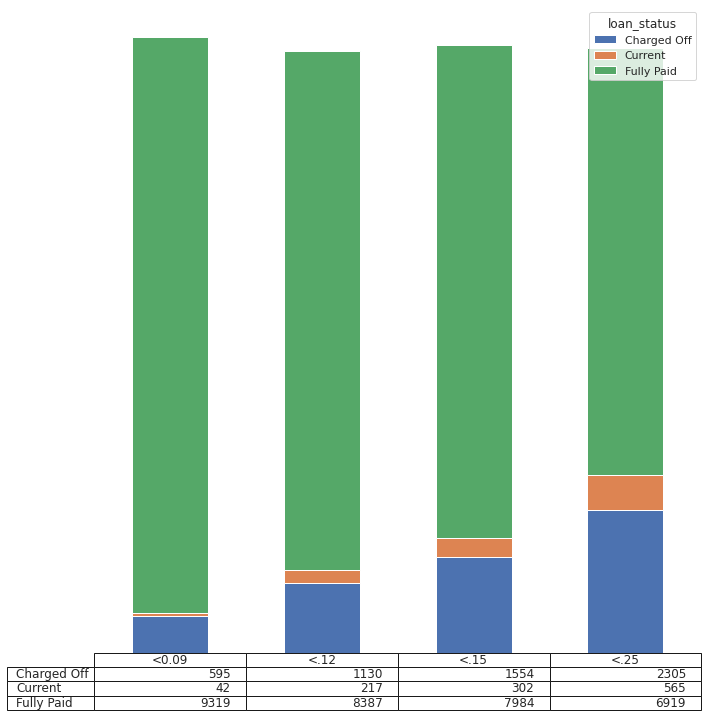

In [ ]:
bar_plot('interest_bin' ,'loan_status', data = loans)

In [ ]:
pd.crosstab([loans.interest_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
interest_bin,,,
<0.09,0.059763,0.004219,0.936018
<.12,0.116088,0.022293,0.861619
<.15,0.157927,0.030691,0.811382
<.25,0.235468,0.057718,0.706814


Higher the Interest rate, higher the chances of loan being charged off

### Loan Amount vs Loan Status

In [ ]:
loans.loan_amnt.describe()

count    39319.000000
mean     11134.114550
std       7376.086312
min        500.000000
25%       5400.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [ ]:
pd.crosstab(index=  [pd.cut(loans.loan_amnt, np.arange(0, np.floor(loans.loan_amnt.max()+5000), 5000),include_lowest=True)],
            columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
loan_amnt,,,
"(-0.001, 5000.0]",0.137432,0.010071,0.852497
"(5000.0, 10000.0]",0.126939,0.012252,0.860810
"(10000.0, 15000.0]",0.132409,0.037831,0.829760
"(15000.0, 20000.0]",0.163945,0.052736,0.783319
"(20000.0, 25000.0]",0.181881,0.055251,0.762869
"(25000.0, 30000.0]",0.186755,0.111258,0.701987
"(30000.0, 35000.0]",0.227632,0.115789,0.656579


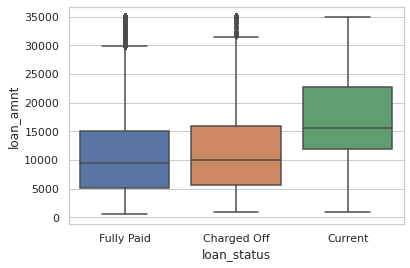

In [ ]:
sns.boxplot(y=loans.loan_amnt , x= loans.loan_status)

Higher the loan amount, higher the chances of loan being charged off

### Annual Income vs Loan Status

In [ ]:
loans.annual_inc.describe()

count     39319.000000
mean      65524.215803
std       35215.885297
min        4000.000000
25%       40000.000000
50%       58000.000000
75%       81000.000000
max      234996.000000
Name: annual_inc, dtype: float64

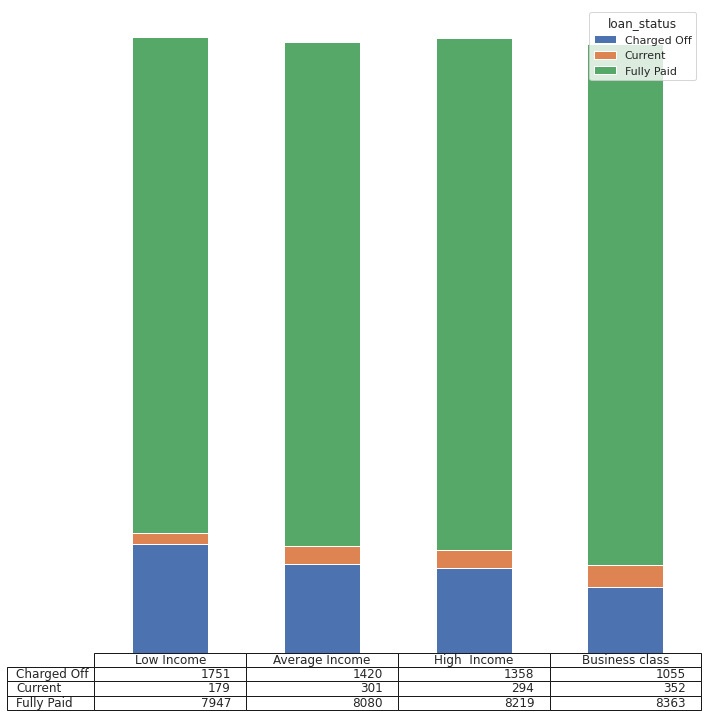

In [ ]:
loans['annual_inc_bin'] = pd.qcut(loans.annual_inc, 4, labels=['Low Income','Average Income','High  Income' ,'Business class'],duplicates = 'drop')
bar_plot(x='annual_inc_bin',y='loan_status' ,data = loans)

In [ ]:
pd.crosstab(index=  [loans.annual_inc_bin],
          columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count', normalize='index' )

loan_status,Charged Off,Current,Fully Paid
annual_inc_bin,,,
Low Income,0.177281,0.018123,0.804597
Average Income,0.144883,0.030711,0.824406
High Income,0.137575,0.029784,0.832641
Business class,0.107984,0.036029,0.855988


lower the annual income, higher the chances of loan being charged off.

### dti vs Loan Status

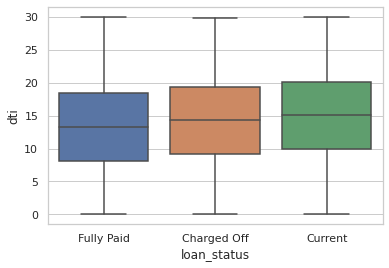

In [ ]:
sns.boxplot(y=loans.dti , x= loans.loan_status) 

In [ ]:
loans['dti_bin'] = pd.qcut(loans.dti, 4, labels=False,duplicates = 'drop')
pd.crosstab([loans.dti_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
dti_bin,,,
0,0.122281,0.020431,0.857288
1,0.134201,0.028569,0.837231
2,0.150519,0.028699,0.820782
3,0.161116,0.036867,0.802016


dti seems to not have any impact on loan status

### CHECK ON FICO SCORE 

In [ ]:
loans['fico']=loans.desc.apply(lambda x : 1 if re.search('fico' ,x ) else 0 )

In [ ]:
pd.crosstab([loans.fico  ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
fico,,,
0,0.141876,0.028655,0.829469
1,0.375000,0.000000,0.625000


In [ ]:
loans_fico =loans[loans.fico == 1]
pd.crosstab([loans_fico.purpose  ],loans_fico.loan_status,values=loans_fico.loan_amnt,aggfunc='count',
           normalize='columns')

loan_status,Charged Off,Fully Paid
purpose,,
car,0.111111,0.000000
credit_card,0.111111,0.066667
debt_consolidation,0.666667,0.533333
house,0.000000,0.066667
major_purchase,0.000000,0.066667
other,0.111111,0.133333
small_business,0.000000,0.133333


Higher chances of loan getting charged off if fico is mentioned on desc<br>
The cases where charged off is higher are mostly(~88%) debt consolidation/other when Fico is mentioned.

## BIVARIATE ANALYSIS

In [ ]:
rs = np.random.RandomState(0)
cor = loans[['annual_inc','collection_recovery_fee','dti','inq_last_6mths','installment','last_pymnt_amnt','loan_amnt','open_acc','out_prncp','out_prncp_inv','pub_rec','pub_rec_bankruptcies','revol_bal','revol_util','total_acc','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp']].corr()
cor.style.background_gradient(cmap='coolwarm')

,annual_inc,collection_recovery_fee,dti,inq_last_6mths,installment,last_pymnt_amnt,loan_amnt,open_acc,out_prncp,out_prncp_inv,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp
annual_inc,1.000000,0.021887,-0.108919,0.036242,0.413737,0.217197,0.415993,0.261523,0.057953,0.057734,-0.021474,-0.008646,0.423836,0.042729,0.377484,0.395080,0.380488,0.282644,0.013974,0.397341
collection_recovery_fee,0.021887,1.000000,0.012109,0.013098,0.075003,-0.041731,0.072441,0.005216,-0.011378,-0.011366,-0.005276,-0.009850,0.023132,0.026589,0.009191,0.023959,0.014772,0.032793,0.091114,-0.059552
dti,-0.108919,0.012109,1.000000,0.004094,0.063923,0.010682,0.075917,0.292775,0.037654,0.037577,-0.005462,0.031105,0.244185,0.279353,0.236906,0.074074,0.080649,0.113449,-0.011220,0.050456
inq_last_6mths,0.036242,0.013098,0.004094,1.000000,0.006609,0.027020,0.006237,0.090987,-0.010962,-0.010629,0.025753,0.004929,-0.023968,-0.067521,0.109600,-0.013437,-0.023021,0.020578,0.031109,-0.026733
installment,0.413737,0.075003,0.063923,0.006609,1.000000,0.399923,0.929720,0.169360,0.125424,0.125267,-0.045234,-0.025855,0.306406,0.098375,0.224671,0.855475,0.815613,0.634129,0.057831,0.848611
last_pymnt_amnt,0.217197,-0.041731,0.010682,0.027020,0.399923,1.000000,0.446999,0.077776,-0.066378,-0.066308,-0.031115,0.000456,0.115837,-0.016620,0.161376,0.474222,0.462015,0.190476,-0.060422,0.543185
loan_amnt,0.415993,0.072441,0.075917,0.006237,0.929720,0.446999,1.000000,0.174185,0.194018,0.193691,-0.050005,-0.016489,0.312608,0.068395,0.251251,0.885336,0.852716,0.729667,0.045912,0.849905
open_acc,0.261523,0.005216,0.292775,0.090987,0.169360,0.077776,0.174185,1.000000,0.027760,0.027575,0.001054,0.003857,0.289187,-0.088355,0.685937,0.159594,0.149977,0.121118,-0.017945,0.157944
out_prncp,0.057953,-0.011378,0.037654,-0.010962,0.125424,-0.066378,0.194018,0.027760,1.000000,0.999823,-0.012437,0.002025,0.058336,0.038496,0.031226,0.240279,0.247409,0.384179,-0.004200,0.167605
out_prncp_inv,0.057734,-0.011366,0.037577,-0.010629,0.125267,-0.066308,0.193691,0.027575,0.999823,1.000000,-0.012675,0.001770,0.058113,0.038662,0.031034,0.239949,0.247393,0.383831,-0.004310,0.167309


###Public Records/Bankrupcies/Interest/Late fee

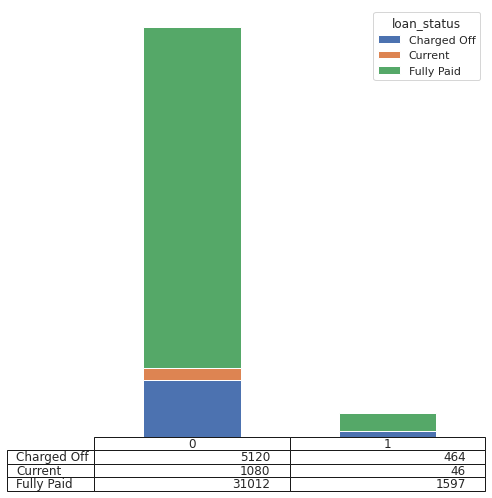

In [ ]:
loans['pub_rec_exists']= loans.pub_rec.apply(lambda x: 1 if x>0 else 0)
bar_plot('pub_rec_exists' , 'loan_status', data=loans, sizerow=7 , sizecolumn=7)

In [ ]:
pd.crosstab([loans.pub_rec_exists],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
pub_rec_exists,,,
0,0.137590,0.029023,0.833387
1,0.220218,0.021832,0.757950


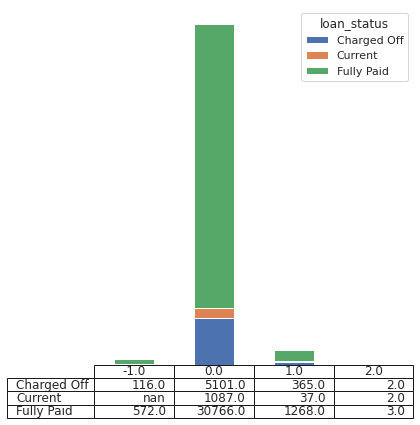

In [ ]:
bar_plot('pub_rec_bankruptcies' , 'loan_status',data=loans, sizerow=6 , sizecolumn=6)

In [ ]:
pd.crosstab([loans.pub_rec_bankruptcies ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
pub_rec_bankruptcies,,,
-1.0,0.168605,0.000000,0.831395
0.0,0.138036,0.029415,0.832549
1.0,0.218563,0.022156,0.759281
2.0,0.285714,0.285714,0.428571


In [ ]:
pd.crosstab([loans.pub_rec_bankruptcies ,loans.pub_rec_exists ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                          Charged Off   Current  Fully Paid
pub_rec_bankruptcies pub_rec_exists                                   
-1.0                 0                  0.164671  0.000000    0.835329
                     1                  0.300000  0.000000    0.700000
 0.0                 0                  0.137095  0.029553    0.833352
                     1                  0.221951  0.017073    0.760976
 1.0                 1                  0.218563  0.022156    0.759281
 2.0                 1                  0.285714  0.285714    0.428571

In [ ]:
pd.crosstab([loans.pub_rec_bankruptcies ,loans.pub_rec_exists ,
             loans.interest_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                       Charged Off  ...  Fully Paid
pub_rec_bankruptcies pub_rec_exists interest_bin               ...            
-1.0                 0              <0.09            0.040936  ...    0.959064
                                    <.12             0.161392  ...    0.838608
                                    <.15             0.283871  ...    0.716129
                                    <.25             0.307692  ...    0.692308
                     1              <0.09            0.000000  ...    1.000000
                                    <.12             0.272727  ...    0.727273
                                    <.15             0.428571  ...    0.571429
                                    <.25             0.000000  ...    1.000000
 0.0                 0              <0.09            0.059715  ...    0.935923
                                    <.12             0.113121  ...    0.862615
                                    <.15             0.152012  ...    0.815279
                                    <.25             0.228708  ...    0.712697
                     1              <0.09            0.095238  ...    0.904762
                                    <.12             0.148148  ...    0.851852
                                    <.15             0.251799  ...    0.733813
                                    <.25             0.248521  ...    0.721893
 1.0                 1              <0.09            0.082090  ...    0.917910
                                    <.12             0.132388  ...    0.865248
                                    <.15             0.194605  ...    0.795761
                                    <.25             0.331650  ...    0.616162
 2.0                 1              <.12             1.000000  ...    0.000000
                                    <.15             0.000000  ...    1.000000
                                    <.25             0.200000  ...    0.400000

[23 rows x 3 columns]

The chances of loan charge off is higher if banrupsies are present , even where no bankrupsy , any public record will increase chances of loan getting wrtten off

In [ ]:
loans.total_rec_late_fee.describe()

count    39319.000000
mean         1.361561
std          7.284208
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        180.200000
Name: total_rec_late_fee, dtype: float64

In [ ]:
loans['late_fee_status'] = loans.total_rec_late_fee.apply(lambda c : 'Yes' if c>1 else 'No')

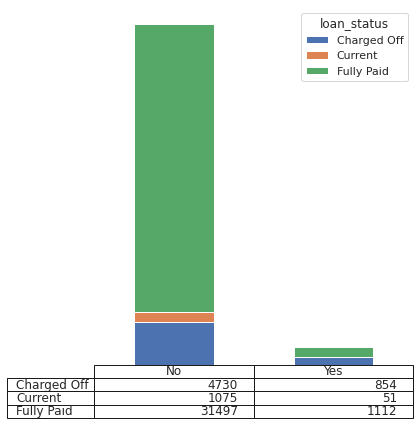

In [ ]:
bar_plot('late_fee_status' , 'loan_status', data=loans, sizerow=6 , sizecolumn=6)

In [ ]:
pd.crosstab([loans.late_fee_status ],loans.loan_status,
            values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
late_fee_status,,,
No,0.126803,0.028819,0.844378
Yes,0.423401,0.025285,0.551314


In [ ]:
pd.crosstab([loans.late_fee_status,loans.pub_rec_bankruptcies ,loans.pub_rec_exists ,
             loans.interest_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                                       Charged Off  ...  Fully Paid
late_fee_status pub_rec_bankruptcies pub_rec_exists interest_bin               ...            
No              -1.0                 0              <0.09            0.030488  ...    0.969512
                                                    <.12             0.135714  ...    0.864286
                                                    <.15             0.257353  ...    0.742647
                                                    <.25             0.250000  ...    0.750000
                                     1              <0.09            0.000000  ...    1.000000
                                                    <.12             0.125000  ...    0.875000
                                                    <.15             0.500000  ...    0.500000
                                                    <.25             0.000000  ...    1.000000
                 0.0                 0              <0.09            0.052576  ...    0.943061
                                                    <.12             0.103032  ...    0.872146
                                                    <.15             0.135339  ...    0.830914
                                                    <.25             0.206535  ...    0.734145
                                     1              <0.09            0.095238  ...    0.904762
                                                    <.12             0.142857  ...    0.857143
                                                    <.15             0.229008  ...    0.755725
                                                    <.25             0.232258  ...    0.735484
                 1.0                 1              <0.09            0.076336  ...    0.923664
                                                    <.12             0.120988  ...    0.876543
                                                    <.15             0.182556  ...    0.807302
                                                    <.25             0.319569  ...    0.628366
                 2.0                 1              <.12             1.000000  ...    0.000000
                                                    <.15             0.000000  ...    1.000000
                                                    <.25             0.250000  ...    0.250000
Yes             -1.0                 0              <0.09            0.285714  ...    0.714286
                                                    <.12             0.361111  ...    0.638889
                                                    <.15             0.473684  ...    0.526316
                                                    <.25             1.000000  ...    0.000000
                                     1              <.12             0.666667  ...    0.333333
                                                    <.15             0.000000  ...    1.000000
                 0.0                 0              <0.09            0.347639  ...    0.648069
                                                    <.12             0.351801  ...    0.637119
                                                    <.15             0.411765  ...    0.571691
                                                    <.25             0.491429  ...    0.458571
                                     1              <.12             0.250000  ...    0.750000
                                                    <.15             0.625000  ...    0.375000
                                                    <.25             0.428571  ...    0.571429
                 1.0                 1              <0.09            0.333333  ...    0.666667
                                                    <.12             0.388889  ...    0.611111
                                                    <.15             0.423077  ...    0.576923
                                                    <.25             0.513514  ...    0.432432
          

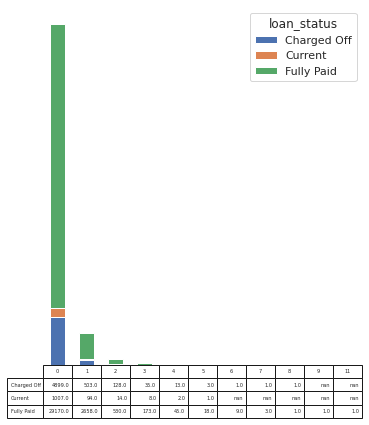

In [ ]:
bar_plot('delinq_2yrs' , 'loan_status',data=loans, sizerow=6 , sizecolumn=6)

In [ ]:
loans['delinq_status'] = loans.delinq_2yrs.apply(lambda c : 'Yes' if c>1 else 'No')

In [ ]:
pd.crosstab([loans.delinq_status, loans.late_fee_status],
            loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                    Charged Off   Current  Fully Paid
delinq_status late_fee_status                                   
No            No                  0.126051  0.028951    0.844998
              Yes                 0.422338  0.024416    0.553247
Yes           No                  0.157366  0.023438    0.819196
              Yes                 0.445652  0.043478    0.510870

In [ ]:
pd.crosstab([loans.delinq_status, loans.late_fee_status,
             loans.pub_rec_bankruptcies ,loans.pub_rec_exists ],
            loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                                        Charged Off  ...  Fully Paid
delinq_status late_fee_status pub_rec_bankruptcies pub_rec_exists               ...            
No            No              -1.0                 0                  0.134251  ...    0.865749
                                                   1                  0.266667  ...    0.733333
                               0.0                 0                  0.121263  ...    0.848871
                                                   1                  0.203209  ...    0.778075
                               1.0                 1                  0.207120  ...    0.771521
                               2.0                 1                  0.333333  ...    0.333333
              Yes             -1.0                 0                  0.409836  ...    0.590164
                                                   1                  0.500000  ...    0.500000
                               0.0                 0                  0.421563  ...    0.552767
                                                   1                  0.461538  ...    0.538462
                               1.0                 1                  0.437500  ...    0.537500
                               2.0                 1                  0.000000  ...    1.000000
Yes           No              -1.0                 0                  0.260870  ...    0.739130
                                                   1                  0.000000  ...    1.000000
                               0.0                 0                  0.152253  ...    0.824604
                                                   1                  0.300000  ...    0.700000
                               1.0                 1                  0.170732  ...    0.780488
              Yes             -1.0                 0                  0.333333  ...    0.666667
                               0.0                 0                  0.435294  ...    0.517647
                               1.0                 1                  0.750000  ...    0.250000

[20 rows x 3 columns]

When there are 2 or more offence , its best to avoid giving loan 

###Revol Util/Income/Open acoount/Interest

In [ ]:
loans.revol_util.describe()

count    39319.000000
mean        48.758531
std         28.343759
min         -1.000000
25%         25.300000
50%         49.200000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64

In [ ]:
loans['Revol_util_bin'] = pd.qcut(loans.revol_util, 4, labels=['Low util','Average util','High  Util' ,'Max Util'],duplicates = 'drop')

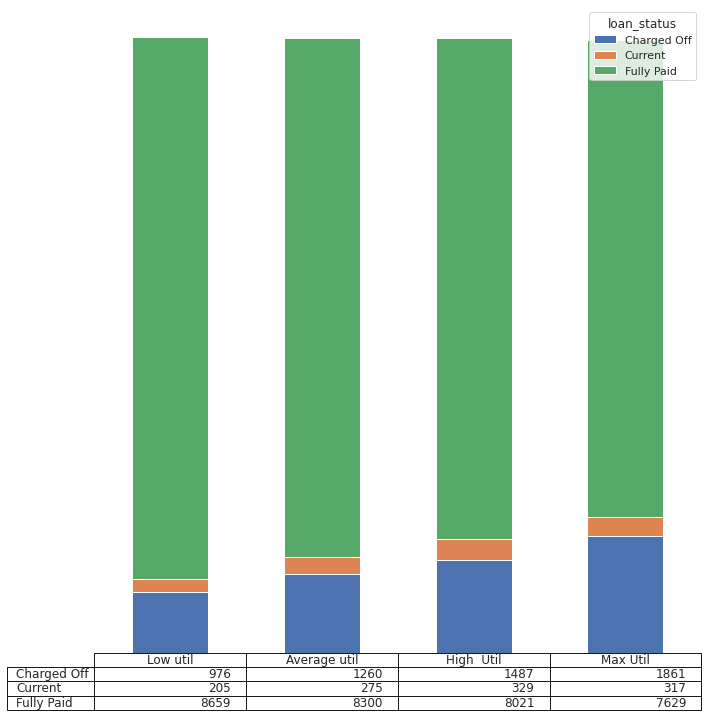

In [ ]:
bar_plot('Revol_util_bin' ,'loan_status', data=loans )

In [ ]:
loans.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'pub_rec_bankruptcies', 'Region',
       'pub_rec_exists', 'interest_bin', 'annual_inc_bin', 'dti_bin', 'fico',
       'late_fee_status', 'delinq_status', 'Revol_util_bin'],
      dtype='object')

In [ ]:
pd.crosstab([loans.term,loans.interest_bin , loans.Revol_util_bin],loans.loan_status , 
            values= loans.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                             Charged Off   Current  Fully Paid
term       interest_bin Revol_util_bin                                   
 36 months <0.09        Low util           0.042680  0.000000    0.957320
                        Average util       0.060681  0.000000    0.939319
                        High  Util         0.086250  0.000000    0.913750
                        Max Util           0.091977  0.000000    0.908023
           <.12         Low util           0.095104  0.000000    0.904896
                        Average util       0.100351  0.000000    0.899649
                        High  Util         0.108303  0.000000    0.891697
                        Max Util           0.121935  0.000000    0.878065
           <.15         Low util           0.159451  0.000000    0.840549
                        Average util       0.139757  0.000000    0.860243
                        High  Util         0.127886  0.000000    0.872114
                        Max Util           0.146399  0.000000    0.853601
           <.25         Low util           0.217687  0.000000    0.782313
                        Average util       0.158598  0.000000    0.841402
                        High  Util         0.178537  0.000000    0.821463
                        Max Util           0.190083  0.000000    0.809917
 60 months <0.09        Low util           0.067797  0.074576    0.857627
                        Average util       0.119718  0.091549    0.788732
                        High  Util         0.135593  0.084746    0.779661
                        Max Util           0.111111  0.222222    0.666667
           <.12         Low util           0.154255  0.115691    0.730053
                        Average util       0.152439  0.118902    0.728659
                        High  Util         0.158291  0.110553    0.731156
                        Max Util           0.201389  0.055556    0.743056
           <.15         Low util           0.179966  0.076401    0.743633
                        Average util       0.206675  0.125802    0.667522
                        High  Util         0.210733  0.133508    0.655759
                        Max Util           0.219713  0.117043    0.663244
           <.25         Low util           0.241779  0.098646    0.659574
                        Average util       0.270161  0.086694    0.643145
                        High  Util         0.259167  0.110628    0.630205
                        Max Util           0.296489  0.108366    0.595145

In [ ]:
loans['open_acc_bin'] = pd.qcut(loans.open_acc, 4, labels=['2-6','7-9','10-12','13-44'], duplicates='drop')
loans_60 = loans[(loans.term == '60 months') & (loans.interest_bin.isin(['<.15','<.25']))]
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin],
            loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

interest_bin,Revol_util_bin


In [ ]:
loans.emp_length.value_counts()

10+ years    8740
< 1 year     4553
2 years      4342
3 years      4059
4 years      3410
5 years      3255
1 year       3213
6 years      2209
7 years      1759
8 years      1462
9 years      1247
Not Given    1070
Name: emp_length, dtype: int64

In [ ]:
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin, loans_60.annual_inc_bin],
            loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

interest_bin,Revol_util_bin,annual_inc_bin


In [ ]:
loans_60 = loans_60[loans_60.Revol_util_bin >'Average util']
loans_60.shape

(0, 54)

In [ ]:
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin,
             loans_60.annual_inc_bin],loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

interest_bin,Revol_util_bin,annual_inc_bin


In [ ]:
loans_60 = loans_60[loans_60.annual_inc_bin < 'High  Income']

In [ ]:
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin,
             loans_60.annual_inc_bin],loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

interest_bin,Revol_util_bin,annual_inc_bin


In [ ]:
loans_60.open_acc_bin.unique()

[], Categories (0, object): []

In [ ]:
loans_60 = loans_60[loans_60.annual_inc_bin == 'Low Income']
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin,
             loans_60.annual_inc_bin,loans_60.open_acc_bin],loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

interest_bin,Revol_util_bin,annual_inc_bin,open_acc_bin


###Interest Rates/Employee length/Grade

Binning Interest rates into quartiles

In [ ]:
loans.int_rate.quantile([0.25,0.5,0.75,1])

0.25     9.25
0.50    11.83
0.75    14.54
1.00    24.59
Name: int_rate, dtype: float64

In [ ]:
loans['interest_bin'] = pd.qcut(loans.int_rate, 4, labels=['<0.09' , '<.12' , '<.15' , '<.25'],duplicates = 'drop')

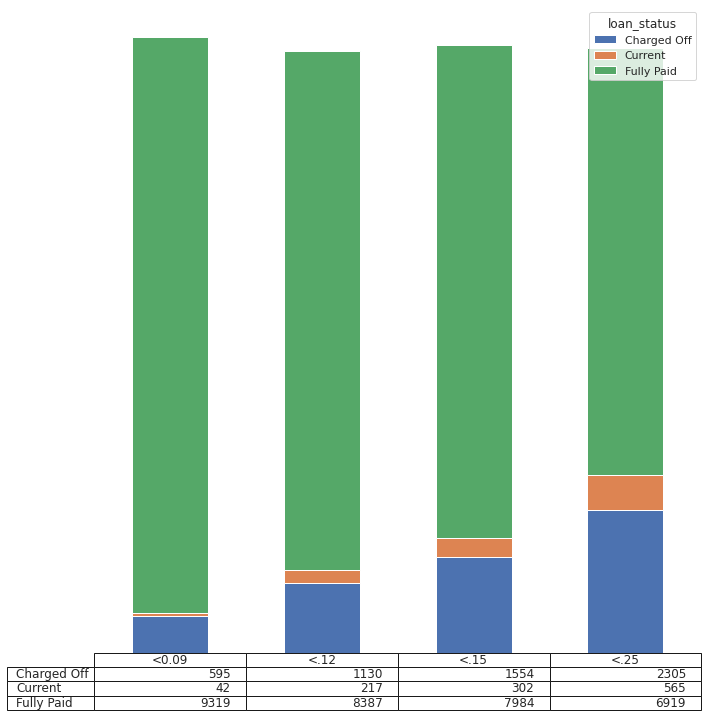

In [ ]:
bar_plot('interest_bin' ,'loan_status', data=loans)

In [ ]:
pd.crosstab([loans.interest_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
interest_bin,,,
<0.09,0.059763,0.004219,0.936018
<.12,0.116088,0.022293,0.861619
<.15,0.157927,0.030691,0.811382
<.25,0.235468,0.057718,0.706814


As the interest rates grow higher the chances of charging off  the loan increases.

In [ ]:
pd.crosstab([loans.emp_length  ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
emp_length,,,
1 year,0.141612,0.021475,0.836913
10+ years,0.150572,0.044165,0.805263
2 years,0.129203,0.022340,0.848457
3 years,0.135748,0.020202,0.844050
4 years,0.133724,0.027566,0.838710
5 years,0.140092,0.026728,0.833180
6 years,0.138072,0.026256,0.835672
7 years,0.148948,0.035247,0.815804
8 years,0.138851,0.029412,0.831737


In [ ]:
pd.crosstab([loans.emp_length , loans.interest_bin ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status              Charged Off   Current  Fully Paid
emp_length interest_bin                                   
1 year     <0.09            0.063114  0.007013    0.929874
           <.12             0.138554  0.006024    0.855422
           <.15             0.134509  0.019846    0.845645
           <.25             0.226737  0.053735    0.719528
10+ years  <0.09            0.061599  0.005242    0.933159
           <.12             0.115679  0.040153    0.844168
           <.15             0.169639  0.052048    0.778313
           <.25             0.254378  0.079685    0.665937
2 years    <0.09            0.049296  0.001006    0.949698
           <.12             0.097540  0.014060    0.888401
           <.15             0.149956  0.022668    0.827376
           <.25             0.215428  0.050800    0.733772
3 years    <0.09            0.058706  0.004975    0.936318
           <.12             0.091522  0.018304    0.890173
           <.15             0.161228  0.016315    0.822457
           <.25             0.235113  0.042094    0.722793
4 years    <0.09            0.050602  0.004819    0.944578
           <.12             0.126536  0.015971    0.857494
           <.15             0.121606  0.033058    0.845336
           <.25             0.226333  0.053319    0.720348
5 years    <0.09            0.056695  0.003619    0.939686
           <.12             0.114713  0.019950    0.865337
           <.15             0.158428  0.036755    0.804816
           <.25             0.229940  0.046707    0.723353
6 years    <0.09            0.052910  0.001764    0.945326
           <.12             0.097928  0.024482    0.877589
           <.15             0.160748  0.016822    0.822430
           <.25             0.237847  0.060764    0.701389
7 years    <0.09            0.042155  0.009368    0.948478
           <.12             0.134571  0.025522    0.839907
           <.15             0.169300  0.040632    0.790068
           <.25             0.242358  0.063319    0.694323
8 years    <0.09            0.052764  0.005025    0.942211
           <.12             0.116279  0.020349    0.863372
           <.15             0.164384  0.027397    0.808219
           <.25             0.230986  0.067606    0.701408
9 years    <0.09            0.063063  0.000000    0.936937
           <.12             0.090032  0.025723    0.884244
           <.15             0.148276  0.031034    0.820690
           <.25             0.207668  0.047923    0.744409
< 1 year   <0.09            0.062769  0.000000    0.937231
           <.12             0.124229  0.008811    0.866960
           <.15             0.153028  0.017185    0.829787
           <.25             0.226525  0.041626    0.731849
Not Given  <0.09            0.120098  0.012255    0.867647
           <.12             0.197761  0.055970    0.746269
           <.15             0.342697  0.050562    0.606742
           <.25             0.296296  0.060185    0.643519

In [ ]:
pd.crosstab([loans.grade , loans.interest_bin ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status         Charged Off   Current  Fully Paid
grade interest_bin                                   
A     <0.09            0.058995  0.004162    0.936843
      <.12             0.083538  0.000000    0.916462
B     <0.09            0.084084  0.000000    0.915916
      <.12             0.114729  0.024031    0.861240
      <.15             0.136612  0.049571    0.813817
C     <0.09            0.000000  0.000000    1.000000
      <.12             0.202020  0.000000    0.797980
      <.15             0.160443  0.026563    0.812993
      <.25             0.199822  0.077265    0.722913
D     <0.09            0.000000  0.000000    1.000000
      <.15             0.210687  0.000000    0.789313
      <.25             0.212432  0.047110    0.740458
E     <0.09            0.000000  0.500000    0.500000
      <.15             0.257143  0.000000    0.742857
      <.25             0.253003  0.063342    0.683655
F     <.25             0.304390  0.069268    0.626341
G     <.25             0.323529  0.055556    0.620915

In [ ]:
loans.open_acc.describe()

count    39319.000000
mean         9.275948
std          4.391065
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64

In [ ]:
loans.open_acc.quantile([0, .25,.50,0.75 ,1])

0.00     2.0
0.25     6.0
0.50     9.0
0.75    12.0
1.00    44.0
Name: open_acc, dtype: float64

In [ ]:
loans['open_acc_bin'] = pd.qcut(loans.open_acc, 4, labels=['2-6','7-9','10-12','13-44'],duplicates = 'drop')

In [ ]:
loans.groupby('open_acc_bin')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
open_acc_bin,,,,,,,,
2-6,11504.0,4.722966,1.205557,2.0,4.0,5.0,6.0,6.0
7-9,11582.0,7.974270,0.813937,7.0,7.0,8.0,9.0,9.0
10-12,8132.0,10.883301,0.807834,10.0,10.0,11.0,12.0,12.0
13-44,8101.0,15.989014,3.224712,13.0,14.0,15.0,17.0,44.0


In [ ]:
loans.open_acc_bin.unique()

[2-6, 10-12, 13-44, 7-9]
Categories (4, object): [2-6 < 7-9 < 10-12 < 13-44]

###Check Grade/Subgrade/Term

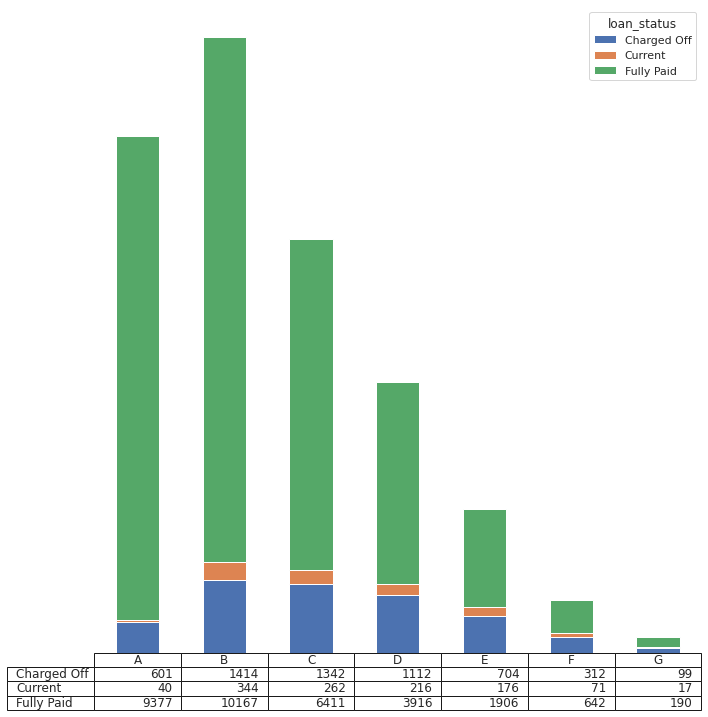

In [ ]:
bar_plot('grade','loan_status', data=loans)

In [ ]:
pd.crosstab(index = [loans.grade] , columns = loans.loan_status , values = loans.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
grade,,,
A,0.059992,0.003993,0.936015
B,0.118574,0.028847,0.852579
C,0.167436,0.032689,0.799875
D,0.212052,0.041190,0.746758
E,0.252692,0.063173,0.684135
F,0.304390,0.069268,0.626341
G,0.323529,0.055556,0.620915


In [ ]:
pd.crosstab(index = [loans.term ,loans.grade] , columns = loans.loan_status , values = loans.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status       Charged Off   Current  Fully Paid
term       grade                                   
 36 months A         0.058848  0.000000    0.941152
           B         0.105440  0.000000    0.894560
           C         0.147927  0.000000    0.852073
           D         0.180734  0.000000    0.819266
           E         0.202353  0.000000    0.797647
           F         0.253659  0.000000    0.746341
           G         0.363636  0.000000    0.636364
 60 months A         0.085253  0.092166    0.822581
           B         0.163928  0.128454    0.707618
           C         0.215239  0.112785    0.671976
           D         0.260574  0.105007    0.634419
           E         0.274793  0.090909    0.634298
           F         0.317073  0.086585    0.596341
           G         0.314741  0.067729    0.617530

In [ ]:
pd.crosstab(index = [loans.grade,loans.sub_grade,loans.term ] , columns = [loans.loan_status] , values = loans.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status                 Charged Off   Current  Fully Paid
grade sub_grade term                                         
A     A1         36 months     0.026502  0.000000    0.973498
      A2         36 months     0.049158  0.000000    0.950842
                 60 months     0.071429  0.000000    0.928571
      A3         36 months     0.058020  0.000000    0.941980
                 60 months     0.024390  0.000000    0.975610
...                                 ...       ...         ...
G     G3         60 months     0.348837  0.069767    0.581395
      G4         36 months     0.333333  0.000000    0.666667
                 60 months     0.204545  0.045455    0.750000
      G5         36 months     0.600000  0.000000    0.400000
                 60 months     0.210526  0.052632    0.736842

[69 rows x 3 columns]

###Home Ownership ,Verification Status and Term

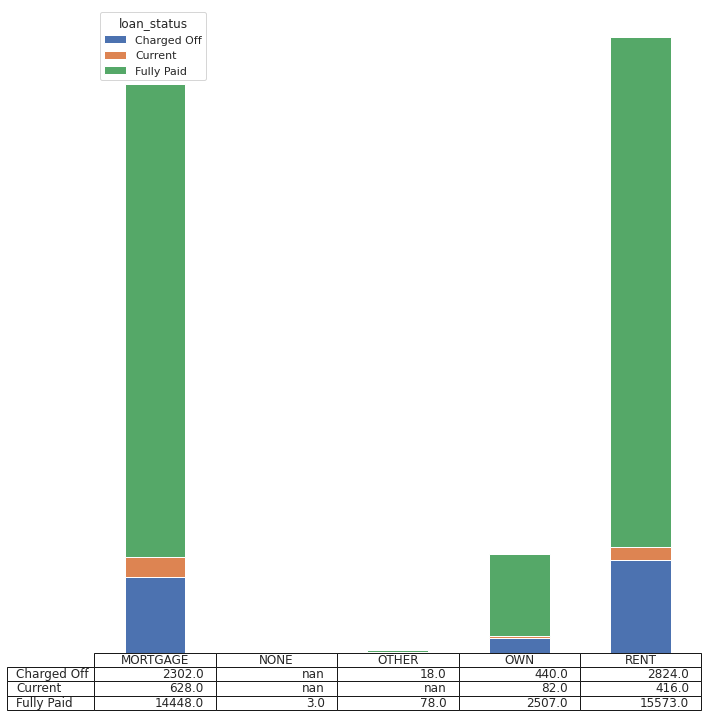

In [ ]:
bar_plot('home_ownership','loan_status',data = loans)

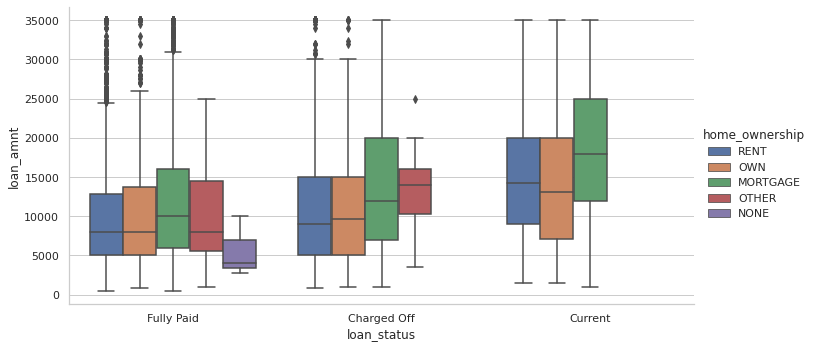

In [ ]:
sns.catplot(x="loan_status", y="loan_amnt", hue="home_ownership", kind="box", data=loans,height=5, aspect=2)

In [ ]:
pd.crosstab(index=  [loans.home_ownership],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
home_ownership,,,
MORTGAGE,0.132466,0.036138,0.831396
NONE,0.000000,0.000000,1.000000
OTHER,0.187500,0.000000,0.812500
OWN,0.145262,0.027072,0.827666
RENT,0.150109,0.022112,0.827779


In [ ]:
pd.crosstab(index=  [loans.term,loans.home_ownership],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status                Charged Off   Current  Fully Paid
term       home_ownership                                   
 36 months MORTGAGE           0.098848  0.000000    0.901152
           NONE               0.000000  0.000000    1.000000
           OTHER              0.178947  0.000000    0.821053
           OWN                0.109697  0.000000    0.890303
           RENT               0.120721  0.000000    0.879279
 60 months MORTGAGE           0.203697  0.112706    0.683597
           OTHER              1.000000  0.000000    0.000000
           OWN                0.253333  0.109333    0.637333
           RENT               0.253113  0.099617    0.647270

In [ ]:
pd.crosstab(index= [loans.verification_status,loans.home_ownership,loans.term ] ,
            columns= [loans.loan_status] , values= loans.loan_amnt ,aggfunc= 'count',normalize= 'index')

loan_status                                    Charged Off  ...  Fully Paid
verification_status home_ownership term                     ...            
Not Verified        MORTGAGE        36 months     0.102412  ...    0.897588
                                    60 months     0.196000  ...    0.711200
                    NONE            36 months     0.000000  ...    1.000000
                    OTHER           36 months     0.176471  ...    0.823529
                                    60 months     1.000000  ...    0.000000
                    OWN             36 months     0.113885  ...    0.886115
                                    60 months     0.211340  ...    0.670103
                    RENT            36 months     0.122001  ...    0.877999
                                    60 months     0.212408  ...    0.695058
Source Verified     MORTGAGE        36 months     0.080943  ...    0.919057
                                    60 months     0.204730  ...    0.683666
                    OTHER           36 months     0.100000  ...    0.900000
                    OWN             36 months     0.093690  ...    0.906310
                                    60 months     0.276151  ...    0.606695
                    RENT            36 months     0.119317  ...    0.880683
                                    60 months     0.265850  ...    0.642651
Verified            MORTGAGE        36 months     0.105962  ...    0.894038
                                    60 months     0.206467  ...    0.671943
                    OTHER           36 months     0.205882  ...    0.794118
                    OWN             36 months     0.116034  ...    0.883966
                                    60 months     0.261830  ...    0.640379
                    RENT            36 months     0.119537  ...    0.880463
                                    60 months     0.264562  ...    0.626021

[23 rows x 3 columns]

###Purpose/Term

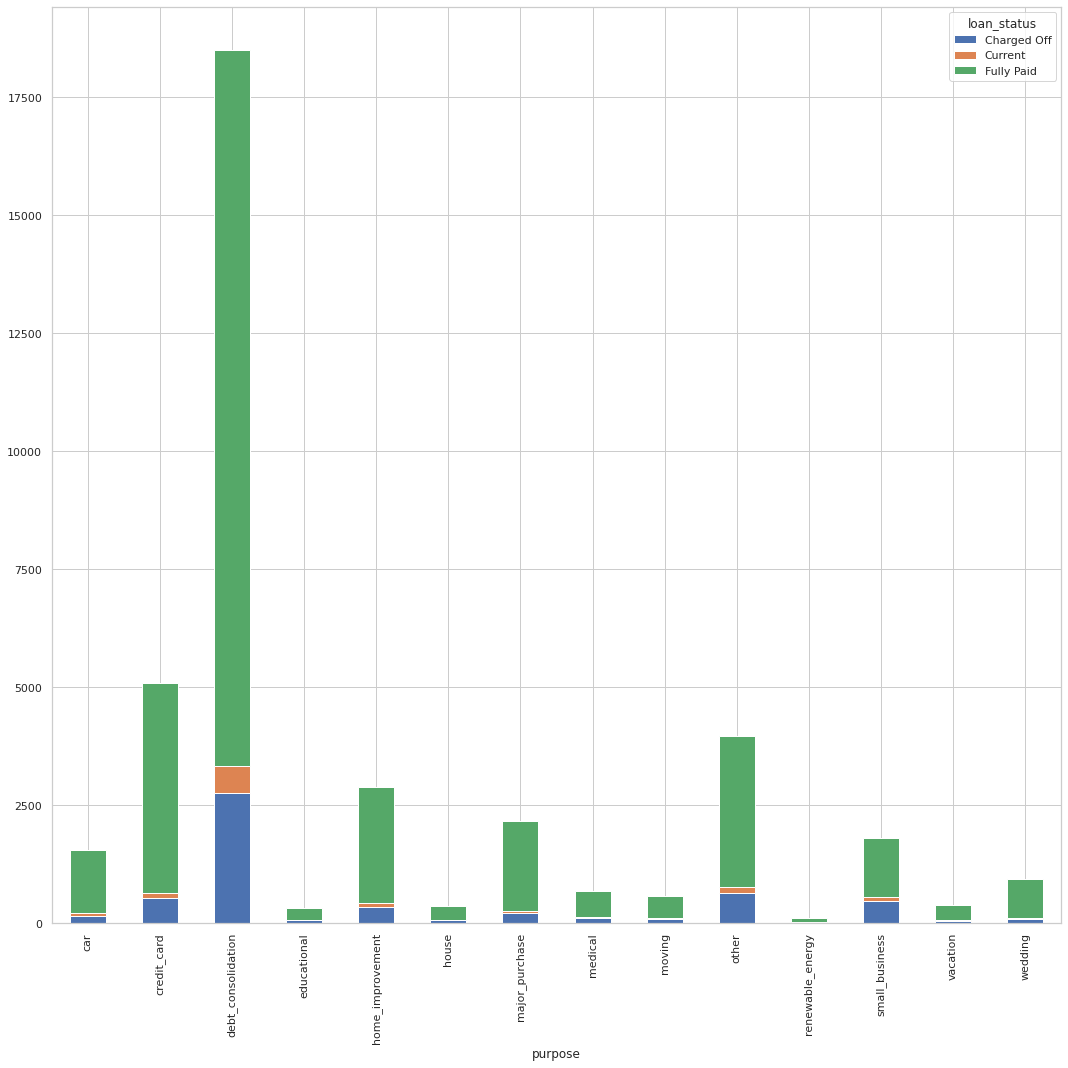

In [ ]:
bar_plot('purpose', 'loan_status',data=loans, tabletoggle= False,sizecolumn= 15 , sizerow= 15,axistoggle= 'on')

In [ ]:
pd.crosstab([loans.purpose],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
purpose,,,
car,0.103761,0.032425,0.863813
credit_card,0.105522,0.020043,0.874435
debt_consolidation,0.148781,0.031356,0.819863
educational,0.170279,0.000000,0.829721
home_improvement,0.116793,0.033518,0.849689
house,0.156334,0.037736,0.805930
major_purchase,0.101570,0.017082,0.881348
medical,0.154519,0.017493,0.827988
moving,0.157712,0.012132,0.830156


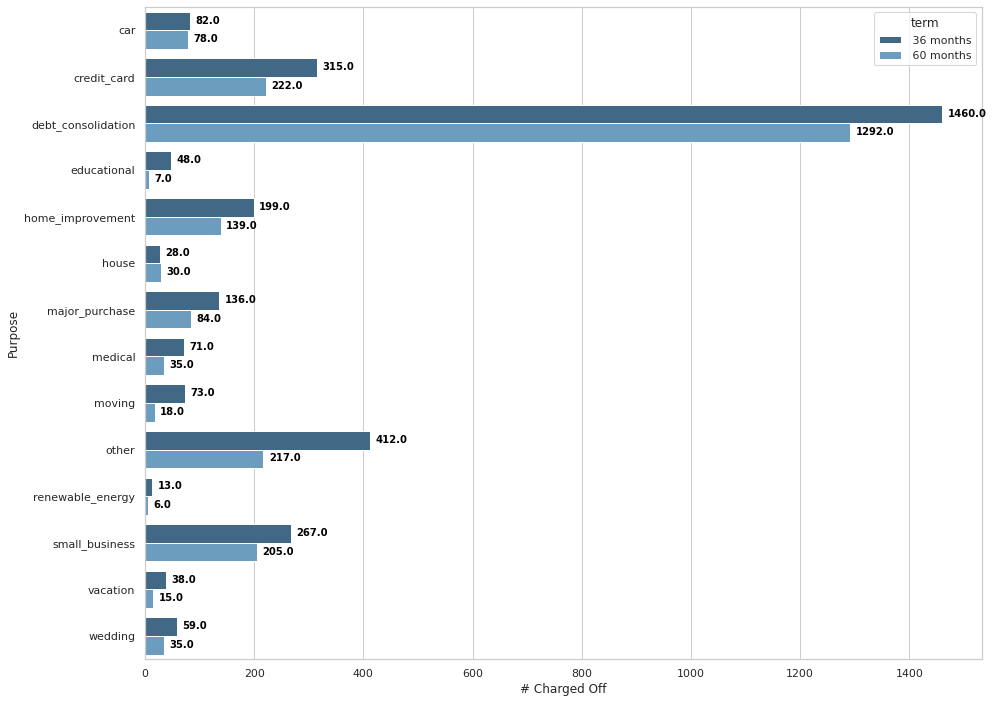

In [ ]:
loans_d= pd.crosstab([loans.purpose ,loans.term ],[loans.loan_status],
                     values=loans.loan_amnt,aggfunc='count').reset_index().fillna(0)
fig, ax = plt.subplots(figsize=(15,12))
sns.set(style = 'whitegrid')
sns.barplot(x = 'Charged Off' ,y ='purpose',data =  loans_d ,hue = 
            'term' ,palette= 'Blues_d').set(
                xlabel ='# Charged Off' , ylabel= 'Purpose')
#to get values next to bar plots(THIS WILL THROW WARNINGS , WHICH IS IGNORED)
for i in ax.patches:
    ax.text(i.get_width()+10, i.get_y()+0.25, str(round((i.get_width()), 2)),
            fontsize=10, fontweight='bold', color='black')
plt.show()


In [ ]:
pd.crosstab([loans.purpose ,loans.term ],[loans.loan_status],values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status                    Charged Off   Current  Fully Paid
purpose            term                                         
car                 36 months     0.083588  0.000000    0.916412
                    60 months     0.139037  0.089127    0.771836
credit_card         36 months     0.077644  0.000000    0.922356
                    60 months     0.215116  0.098837    0.686047
debt_consolidation  36 months     0.111937  0.000000    0.888063
                    60 months     0.236890  0.106344    0.656766
educational         36 months     0.156352  0.000000    0.843648
                    60 months     0.437500  0.000000    0.562500
home_improvement    36 months     0.098710  0.000000    0.901290
                    60 months     0.158314  0.110478    0.731207
house               36 months     0.109804  0.000000    0.890196
                    60 months     0.258621  0.120690    0.620690
major_purchase      36 months     0.079579  0.000000    0.920421
                    60 months     0.183807  0.080963    0.735230
medical             36 months     0.136015  0.000000    0.863985
                    60 months     0.213415  0.073171    0.713415
moving              36 months     0.152401  0.000000    0.847599
                    60 months     0.183673  0.071429    0.744898
other               36 months     0.132263  0.000000    0.867737
                    60 months     0.257414  0.149466    0.593120
renewable_energy    36 months     0.173333  0.000000    0.826667
                    60 months     0.230769  0.038462    0.730769
small_business      36 months     0.219392  0.000000    0.780608
                    60 months     0.353448  0.127586    0.518966
vacation            36 months     0.118380  0.000000    0.881620
                    60 months     0.250000  0.100000    0.650000
wedding             36 months     0.081604  0.000000    0.918396
                    60 months     0.163551  0.093458    0.742991

In [ ]:
#df.verification_status,df.home_ownership,
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.crosstab([loans.verification_status,loans.purpose ,loans.term ],[loans.loan_status],values=loans.loan_amnt,aggfunc='count',
           normalize='index')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


loan_status                                        Charged Off   Current  \
verification_status purpose            term                                
Not Verified        car                 36 months  0.070144     0.000000   
                                        60 months  0.110687     0.106870   
                    credit_card         36 months  0.077381     0.000000   
                                        60 months  0.190083     0.090909   
                    debt_consolidation  36 months  0.113991     0.000000   
                                        60 months  0.215084     0.086592   
                    educational         36 months  0.146789     0.000000   
                                        60 months  0.600000     0.000000   
                    home_improvement    36 months  0.106758     0.000000   
                                        60 months  0.166667     0.072917   
                    house               36 months  0.131579     0.000000   
                                        60 months  0.375000     0.083333   
                    major_purchase      36 months  0.084875     0.000000   
                                        60 months  0.148438     0.085938   
                    medical             36 months  0.153543     0.000000   
                                        60 months  0.215686     0.039216   
                    moving              36 months  0.133333     0.000000   
                                        60 months  0.185185     0.037037   
                    other               36 months  0.139612     0.000000   
                                        60 months  0.249012     0.146245   
                    renewable_energy    36 months  0.181818     0.000000   
                                        60 months  0.750000     0.000000   
                    small_business      36 months  0.226027     0.000000   
                                        60 months  0.380282     0.140845   
                    vacation            36 months  0.124183     0.000000   
                                        60 months  0.238095     0.095238   
                    wedding             36 months  0.082111     0.000000   
                                        60 months  0.081081     0.135135   
Source Verified     car                 36 months  0.080153     0.000000   
                                        60 months  0.155440     0.077720   
                    credit_card         36 months  0.081590     0.000000   
                                        60 months  0.252174     0.091304   
                    debt_consolidation  36 months  0.104992     0.000000   
                                        60 months  0.244614     0.097985   
                    educational         36 months  0.107143     0.000000   
                                        60 months  0.250000     0.000000   
                    home_improvement    36 months  0.094092     0.000000   
                                        60 months  0.173585     0.120755   
                    house               36 months  0.132353     0.000000   
                                        60 months  0.346154     0.076923   
                    major_purchase      36 months  0.065909     0.000000   
                                        60 months  0.232258     0.077419   
                    medical             36 months  0.114865     0.000000   
                                        60 months  0.236364     0.036364   
                    moving              36 months  0.205882     0.000000   
                                        60 months  0.250000     0.055556   
                    other               36 months  0.116959     0.000000   
                                        60 months  0.278431     0.149020   
                    renewable_energy    36 months  0.107143     0.000000   
                                        60 months  0.100000     0.000000   
                    small_business      36 month

Long term loans for vacation , education ,small business ,credit card or for no reasons is a bad idea